The objective of this notebook is to intersect the sample metadata with the taxonomic profiling information to see the top 20-25 groups for each individual over the time series of the sampling.

- load sample metadata
- order metadata by sample timestamp
- group sample metadata by participant
- for each participant, plot the relative abundances of their top 20-25 taxons (at each level)

In [1]:
import Pkg
pkgs = [
    "Revise",
    "DataFrames",
    "StatsBase",
    "StatsPlots",
    "uCSV",
    "ProgressMeter",
    "Distances",
    "Clustering",
    "Colors",
    "MultivariateStats",
    "Dates",
    "CategoricalArrays",
    "GLM",
    "MLJ",
    "Statistics"
]
# Pkg.add(pkgs)
for pkg in pkgs
    eval(Meta.parse("import $pkg"))
end
import Mycelia

[ Info: Precompiling Mycelia [453d265d-8292-4a7b-a57c-dce3f9ae6acd]
[ Info: Skipping precompilation since __precompile__(false). Importing Mycelia [453d265d-8292-4a7b-a57c-dce3f9ae6acd].


In [2]:
data_dir = joinpath(dirname(pwd()), "data")

"/oak/stanford/scg/lab_mpsnyder/cjprybol/Mycelia/projects/viral-exposome-discovery/data"

In [3]:
sample_paths = filter(x -> !occursin(".ipynb_checkpoints", x), readdir(joinpath(data_dir, "SRA"), join=true))

594-element Vector{String}:
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 39 bytes ⋯ "e-discovery/data/SRA/SRR6399459"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 39 bytes ⋯ "e-discovery/data/SRA/SRR6399460"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 39 bytes ⋯ "e-discovery/data/SRA/SRR6399461"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 39 bytes ⋯ "e-discovery/data/SRA/SRR6399462"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 39 bytes ⋯ "e-discovery/data/SRA/SRR6399463"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 39 bytes ⋯ "e-discovery/data/SRA/SRR6399464"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 39 bytes ⋯ "e-discovery/data/SRA/SRR6399465"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 39 bytes ⋯ "e-discovery/data/SRA/SRR6399466"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 39 bytes ⋯ "e-discovery/data/SRA/SRR6399467"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 39 bytes ⋯ "e-discovery/data/SRA/SRR6399468"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 39 bytes ⋯ "e-discovery/data/SRA/SRR6399469"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 39 bytes ⋯ "e-discovery/data/SRA/

In [4]:
results_dir = joinpath(data_dir, "results")

"/oak/stanford/scg/lab_mpsnyder/cjprybol/Mycelia/projects/viral-exposome-discovery/data/results"

In [5]:
# load in metadata
metadata_dir = joinpath(dirname(pwd()), "metadata")

exposome_environmental_data = DataFrames.DataFrame(uCSV.read(
    joinpath(metadata_dir, "metadata_exposome.rds.tsv"),
    delim='\t',
    header=1,
    typedetectrows=300
))

joint_sample_metadata = DataFrames.DataFrame(uCSV.read(
    joinpath(metadata_dir, "exposome/joint_sample_metadata.tsv"),
    delim='\t',
    header=1,
    typedetectrows=300
))

@assert joint_sample_metadata[!, "Library Name"] == joint_sample_metadata[!, "LibraryName"]
joint_metadata = DataFrames.innerjoin(
    joint_sample_metadata,
    exposome_environmental_data,
    on="Library Name" => "samplenames");

# aownership
metadata_by_owner = DataFrames.groupby(joint_metadata, "aownership");

┌ Warning: Large values for `typedetectrows` will reduce performance. Consider manually declaring the types of columns using the `types` argument instead.
└ @ uCSV ~/.julia/packages/uCSV/goLRH/src/read.jl:213
┌ Warning: Large values for `typedetectrows` will reduce performance. Consider manually declaring the types of columns using the `types` argument instead.
└ @ uCSV ~/.julia/packages/uCSV/goLRH/src/read.jl:213


In [6]:
taxon_levels = Mycelia.list_ranks()

9-element Vector{String}:
 "top"
 "superkingdom"
 "kingdom"
 "phylum"
 "class"
 "order"
 "family"
 "genus"
 "species"

In [7]:
viral_tax_ids = Mycelia.list_subtaxa(10239)

241049-element Vector{Int64}:
   10239
   10472
   10473
   46014
   10474
   10475
  174676
  244589
  244590
  459290
  459291
  693628
 2032563
       ⋮
 3044794
 3060633
 3071307
 3044475
 3044704
 3041226
 3044801
 3041225
 3044802
 3041227
 3044808
 3041229

In [ ]:
# # NCBI host metadata
# ncbi_metadata_file = joinpath(dirname(pwd()), "metadata", "NCBI-virus-refseq.transformed.tsv")
# ncbi_host_metadata = DataFrames.DataFrame(uCSV.read(ncbi_metadata_file, header=1, delim='\t', encodings=Dict("false" => false, "true" => true)))

# # ICTV host metadata
# ictv_metadata_file = joinpath(dirname(pwd()), "metadata", "VMR_MSL38_v1 - VMR MSL38 v1.transformed.tsv")
# ictv_host_metadata = DataFrames.DataFrame(uCSV.read(ictv_metadata_file, header=1, delim='\t', typedetectrows=100))
# ictv_host_metadata = ictv_host_metadata[.!isempty.(ictv_host_metadata[!, "taxid"]), :]
# ictv_host_metadata[!, "taxid"] = parse.(Int, ictv_host_metadata[!, "taxid"])

# # # # VirusHostDB metadata
# # virushostdb_metadata_file = joinpath(dirname(pwd()), "metadata", "virushostdb.transformed.tsv")
# # virushostdb_metadata = DataFrames.DataFrame(uCSV.read(virushostdb_metadata_file, header=1, delim='\t', typedetectrows=1086, encodings=Dict("missing" => missing, "false" => false, "true" => true)))

In [8]:
i = 1
# i = 2
# i = 3
# i = 4
# i = 5
# i = 6
# needed subsetting from here
# i = 7
# i = 8
# DONT DO 9
# i = 9

(taxon_index, taxon_level) = collect(enumerate(taxon_levels))[i]
println("$(taxon_index) - $(taxon_level)")
rank_table = Mycelia.list_rank(taxon_level)

1 - top


2×2 DataFrame
 Row │ taxid  name         
     │ Int64  String       
─────┼─────────────────────
   1 │     0  unclassified
   2 │     1  root

In [9]:
# get a list of all viral taxids across the databases
if i <= 2
    filtered_tax_ids = Set(rank_table[!, "taxid"])
elseif i > 2
    filtered_tax_ids = Set(viral_tax_ids)
    filtered_rank_table = rank_table[map(taxid -> taxid in filtered_tax_ids, rank_table[!, "taxid"]), :]
    filtered_tax_ids = Set(filtered_rank_table[!, "taxid"])
end

Set{Int64} with 2 elements:
  0
  1

In [10]:
kraken_db = "k2_pluspfp"
kraken_db_regex = Regex("$(kraken_db)_\\d{8}")

r"k2_pluspfp_\d{8}"

In [11]:
cross_sample_taxon_report = joinpath(results_dir, "$(kraken_db).$(taxon_level).ictv.tsv")

"/oak/stanford/scg/lab_mpsnyder/cjprybol/Mycelia/projects/viral-exposome-discovery/data/results/k2_pluspfp.top.ictv.tsv"

In [12]:
cross_sample_taxon_figure_png = joinpath(results_dir, "$(kraken_db).$(taxon_level).ictv.png")

"/oak/stanford/scg/lab_mpsnyder/cjprybol/Mycelia/projects/viral-exposome-discovery/data/results/k2_pluspfp.top.ictv.png"

In [13]:
exposome_kraken_reports = map(path ->
    first(filter(x -> occursin(kraken_db_regex, x) && occursin(r"kraken-report\.tsv$", x), readdir(joinpath(path, "kraken"), join=true))),
    sample_paths)
# kraken_dirs = filter(x -> occursin(r"Kraken2", x), readdir(joinpath(data_dir, "ultimagen-snyder"), join=true))
# ultima_kraken_reports = reduce(vcat, [readdir(kraken_dir, join=true) for kraken_dir in kraken_dirs])
# ipop_kraken_reports = readdir(joinpath(data_dir, "ultimagen-snyder/ipop/kraken2"), join=true)
# joint_kraken_reports = vcat(exposome_kraken_reports, ultima_kraken_reports, ipop_kraken_reports)
joint_kraken_reports = exposome_kraken_reports

594-element Vector{String}:
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 95 bytes ⋯ "spfp_20221209.kraken-report.tsv"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 95 bytes ⋯ "spfp_20221209.kraken-report.tsv"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 95 bytes ⋯ "spfp_20221209.kraken-report.tsv"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 95 bytes ⋯ "spfp_20221209.kraken-report.tsv"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 95 bytes ⋯ "spfp_20221209.kraken-report.tsv"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 95 bytes ⋯ "spfp_20221209.kraken-report.tsv"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 95 bytes ⋯ "spfp_20221209.kraken-report.tsv"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 95 bytes ⋯ "spfp_20221209.kraken-report.tsv"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 95 bytes ⋯ "spfp_20221209.kraken-report.tsv"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 95 bytes ⋯ "spfp_20221209.kraken-report.tsv"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 95 bytes ⋯ "spfp_20221209.kraken-report.tsv"
 "/oak/stanford/scg/lab_mpsnyder/" ⋯ 95 bytes ⋯ "spfp_20221209.kraken-

In [14]:
cross_sample_taxon_report_table = DataFrames.DataFrame()
# sample_path = first(sample_paths)
ProgressMeter.@showprogress for kraken_report in joint_kraken_reports
    report_table = Mycelia.read_kraken_report(kraken_report)
    taxon_level_report = report_table[map(x -> x in filtered_tax_ids, report_table[!, "ncbi_taxonid"]), :]
    taxon_level_report[!, "sample_identifier"] .= basename(kraken_report)
    append!(cross_sample_taxon_report_table, taxon_level_report)
end
cross_sample_taxon_report_summary = cross_sample_taxon_report_table[!, DataFrames.Not(["percentage_of_fragments_at_or_below_taxon", "number_of_fragments_assigned_directly_to_taxon", "rank"])]
# uCSV.write(cross_sample_taxon_report, cross_sample_taxon_report_table, delim='\t')

Progress: 100%|█████████████████████████████████████████| Time: 0:02:25


1188×4 DataFrame
  Row │ number_of_fragments_at_or_below_taxon  ncbi_taxonid  scientific_name   ⋯
      │ Int64                                  Int64         String            ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │                              44867639             0  unclassified      ⋯
    2 │                              11939597             1  root
    3 │                              55194947             0  unclassified
    4 │                              20297310             1  root
    5 │                              55495847             0  unclassified      ⋯
    6 │                              12585997             1  root
    7 │                              44345317             0  unclassified
    8 │                              18103110             1  root
    9 │                              15286213             0  unclassified      ⋯
   10 │                              31220227             1  root
   11 │                              45530947             0  unclassified
  ⋮   │                   ⋮                         ⋮               ⋮          ⋱
 1179 │                              22492436             0  unclassified
 1180 │                              41849643             1  root              ⋯
 1181 │                              24374533             0  unclassified
 1182 │                              31089240             1  root
 1183 │                               4263352             0  unclassified
 1184 │                              45441980             1  root              ⋯
 1185 │                               5164821             0  unclassified
 1186 │                              97357661             1  root
 1187 │                              34877724             0  unclassified
 1188 │                              23690243             1  root              ⋯
                                                  1 column and 1167 rows omitted

In [15]:
cross_sample_taxon_report_summary[!, "taxon"] = map(row -> string(row["ncbi_taxonid"]) * "_" * row["scientific_name"], DataFrames.eachrow(cross_sample_taxon_report_summary))
# cross_sample_taxon_report_summary = cross_sample_taxon_report_summary[!, DataFrames.Not([
#             "ncbi_taxonid",
#             "scientific_name"
#         ])]

1188-element Vector{String}:
 "0_unclassified"
 "1_root"
 "0_unclassified"
 "1_root"
 "0_unclassified"
 "1_root"
 "0_unclassified"
 "1_root"
 "0_unclassified"
 "1_root"
 "0_unclassified"
 "1_root"
 "0_unclassified"
 ⋮
 "0_unclassified"
 "1_root"
 "0_unclassified"
 "1_root"
 "0_unclassified"
 "1_root"
 "0_unclassified"
 "1_root"
 "0_unclassified"
 "1_root"
 "0_unclassified"
 "1_root"

In [16]:
# assert sortedness & uniqueness (should be a no-op)
unique!(DataFrames.sort!(cross_sample_taxon_report_summary, ["sample_identifier", "taxon"]))

1188×5 DataFrame
  Row │ number_of_fragments_at_or_below_taxon  ncbi_taxonid  scientific_name   ⋯
      │ Int64                                  Int64         String            ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │                              44867639             0  unclassified      ⋯
    2 │                              11939597             1  root
    3 │                              55194947             0  unclassified
    4 │                              20297310             1  root
    5 │                              55495847             0  unclassified      ⋯
    6 │                              12585997             1  root
    7 │                              44345317             0  unclassified
    8 │                              18103110             1  root
    9 │                              15286213             0  unclassified      ⋯
   10 │                              31220227             1  root
   11 │                              45530947             0  unclassified
  ⋮   │                   ⋮                         ⋮               ⋮          ⋱
 1179 │                              22492436             0  unclassified
 1180 │                              41849643             1  root              ⋯
 1181 │                              24374533             0  unclassified
 1182 │                              31089240             1  root
 1183 │                               4263352             0  unclassified
 1184 │                              45441980             1  root              ⋯
 1185 │                               5164821             0  unclassified
 1186 │                              97357661             1  root
 1187 │                              34877724             0  unclassified
 1188 │                              23690243             1  root              ⋯
                                                 2 columns and 1167 rows omitted

In [17]:
cross_sample_taxon_report_summary = cross_sample_taxon_report_summary[cross_sample_taxon_report_summary[!, "number_of_fragments_at_or_below_taxon"] .> 0, :]

1188×5 DataFrame
  Row │ number_of_fragments_at_or_below_taxon  ncbi_taxonid  scientific_name   ⋯
      │ Int64                                  Int64         String            ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │                              44867639             0  unclassified      ⋯
    2 │                              11939597             1  root
    3 │                              55194947             0  unclassified
    4 │                              20297310             1  root
    5 │                              55495847             0  unclassified      ⋯
    6 │                              12585997             1  root
    7 │                              44345317             0  unclassified
    8 │                              18103110             1  root
    9 │                              15286213             0  unclassified      ⋯
   10 │                              31220227             1  root
   11 │                              45530947             0  unclassified
  ⋮   │                   ⋮                         ⋮               ⋮          ⋱
 1179 │                              22492436             0  unclassified
 1180 │                              41849643             1  root              ⋯
 1181 │                              24374533             0  unclassified
 1182 │                              31089240             1  root
 1183 │                               4263352             0  unclassified
 1184 │                              45441980             1  root              ⋯
 1185 │                               5164821             0  unclassified
 1186 │                              97357661             1  root
 1187 │                              34877724             0  unclassified
 1188 │                              23690243             1  root              ⋯
                                                 2 columns and 1167 rows omitted

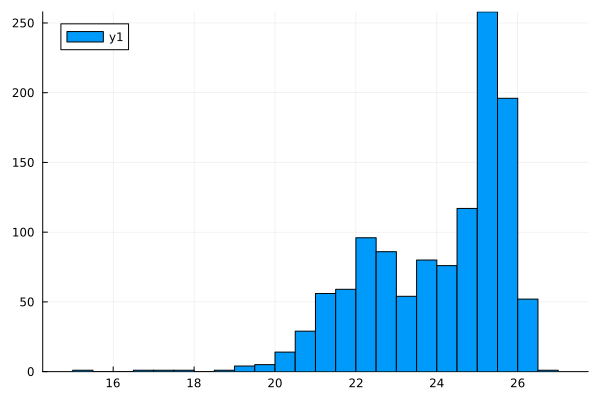

In [18]:
StatsPlots.histogram(log2.(cross_sample_taxon_report_summary[!, "number_of_fragments_at_or_below_taxon"]))

In [19]:
cross_sample_taxon_report_summary = cross_sample_taxon_report_summary[cross_sample_taxon_report_summary[!, "number_of_fragments_at_or_below_taxon"] .>= 3, :]
cross_sample_taxon_report_summary[!, "sample_identifier"] = string.(first.(split.(cross_sample_taxon_report_summary[!, "sample_identifier"], '.')))

# sort(DataFrames.combine(
#     DataFrames.groupby(
#         cross_sample_taxon_report_summary[!, 
#             ["number_of_fragments_at_or_below_taxon", "taxon"]], "taxon"), 
#     "number_of_fragments_at_or_below_taxon" => Statistics.median), "number_of_fragments_at_or_below_taxon_median", rev=true)

sorted_taxa_counts_table = sort(DataFrames.combine(
    DataFrames.groupby(
        cross_sample_taxon_report_summary[!, 
            ["number_of_fragments_at_or_below_taxon", "taxon"]], "taxon"),
    "number_of_fragments_at_or_below_taxon" => Statistics.mean), "number_of_fragments_at_or_below_taxon_mean", rev=true)

# sort(DataFrames.combine(
#     DataFrames.groupby(
#         cross_sample_taxon_report_summary[!, 
#             ["number_of_fragments_at_or_below_taxon", "taxon"]], "taxon"), 
#     "number_of_fragments_at_or_below_taxon" => sum), "number_of_fragments_at_or_below_taxon_sum", rev=true)

2×2 DataFrame
 Row │ taxon           number_of_fragments_at_or_below_taxon_mean 
     │ String          Float64                                    
─────┼────────────────────────────────────────────────────────────
   1 │ 1_root                                           3.17777e7
   2 │ 0_unclassified                                   2.42794e7

In [20]:
unique_taxa = sorted_taxa_counts_table[!, "taxon"]
colorscheme = Colors.distinguishable_colors(length(unique_taxa), [Colors.RGB(1,1,1), Colors.RGB(0,0,0)], dropseed=true)
taxa_to_color = Dict(t => c for (t, c) in zip(unique_taxa, colorscheme))

Dict{String, ColorTypes.RGB{FixedPointNumbers.N0f8}} with 2 entries:
  "1_root"         => RGB{N0f8}(0.78,0.129,0.867)
  "0_unclassified" => RGB{N0f8}(0.82,0.29,0.0)

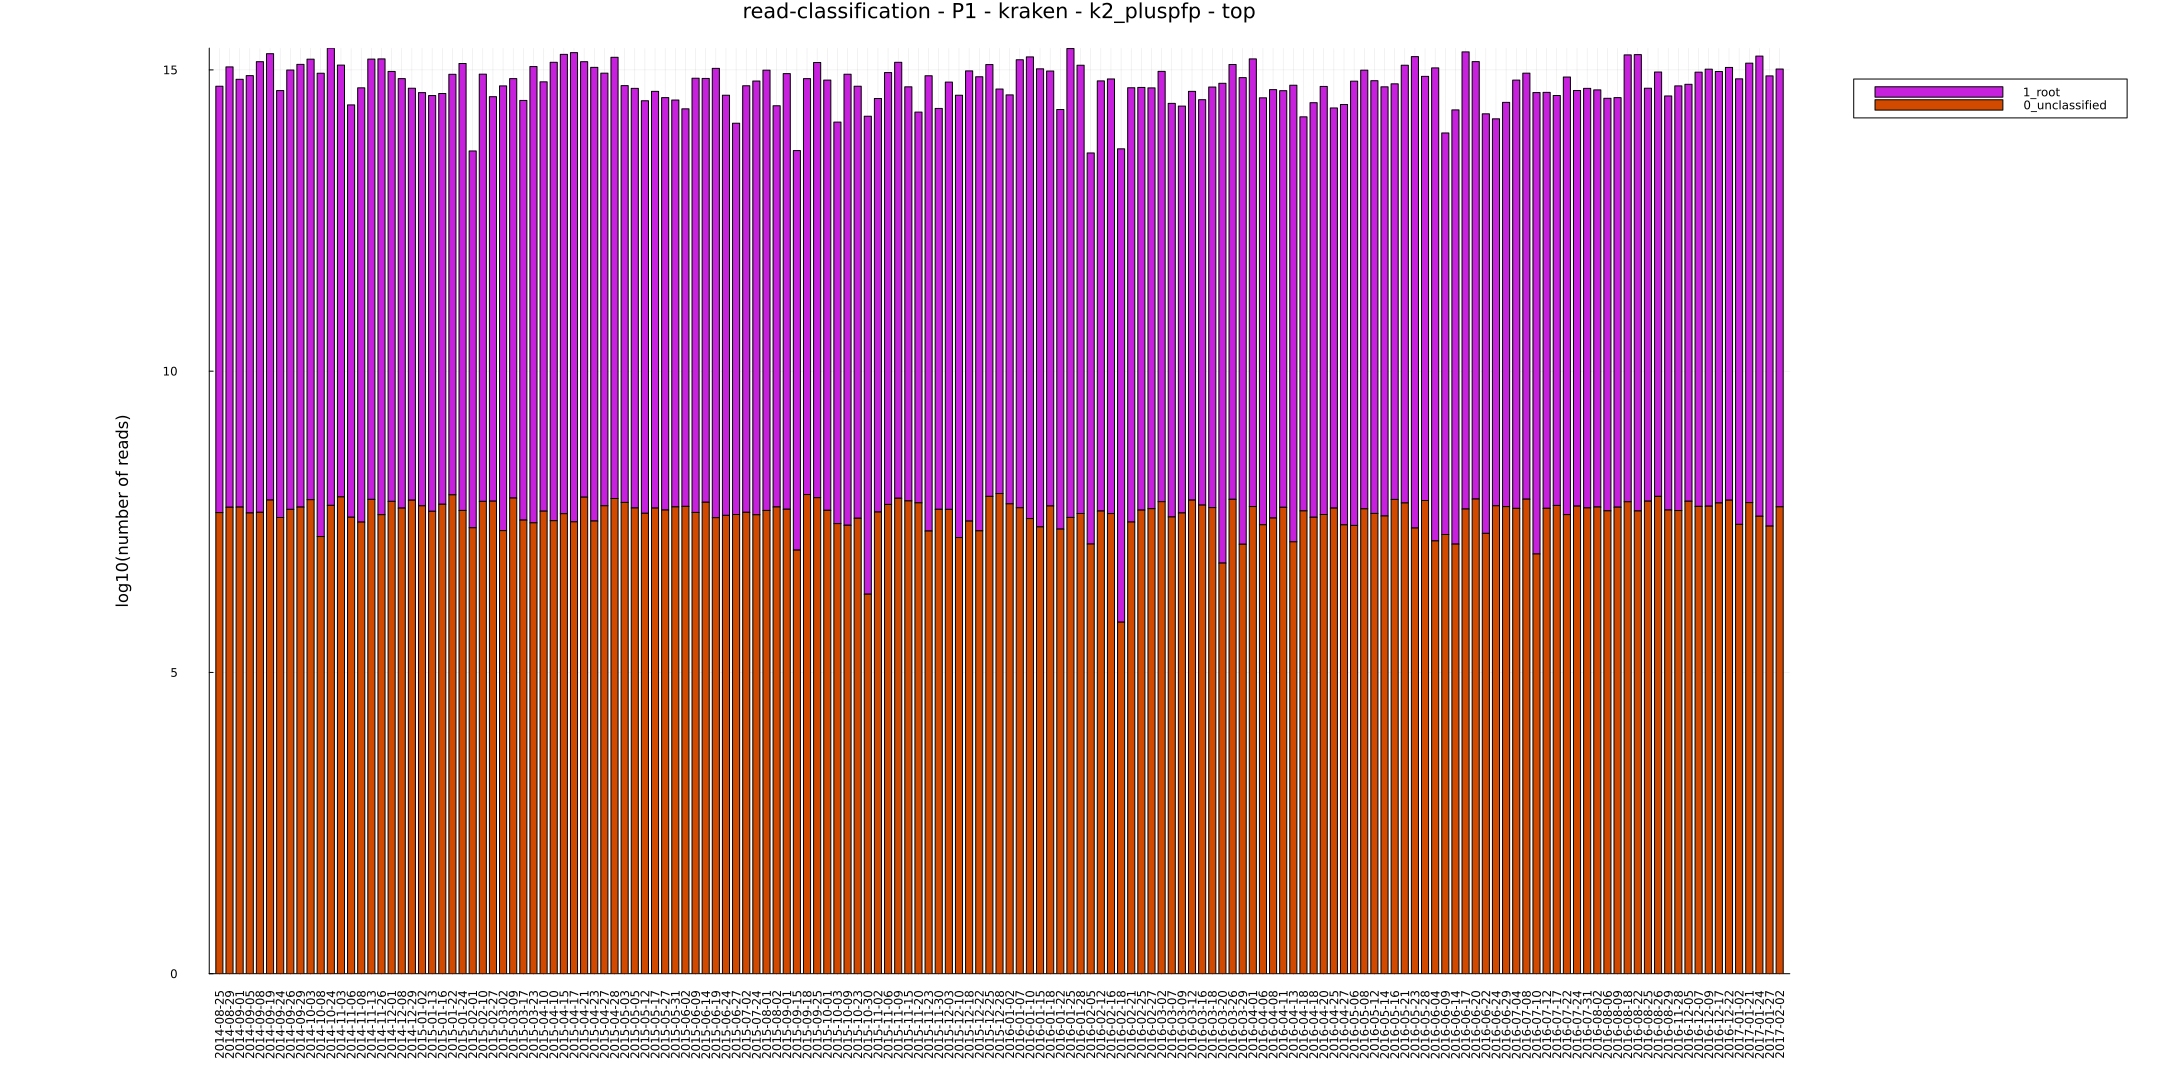

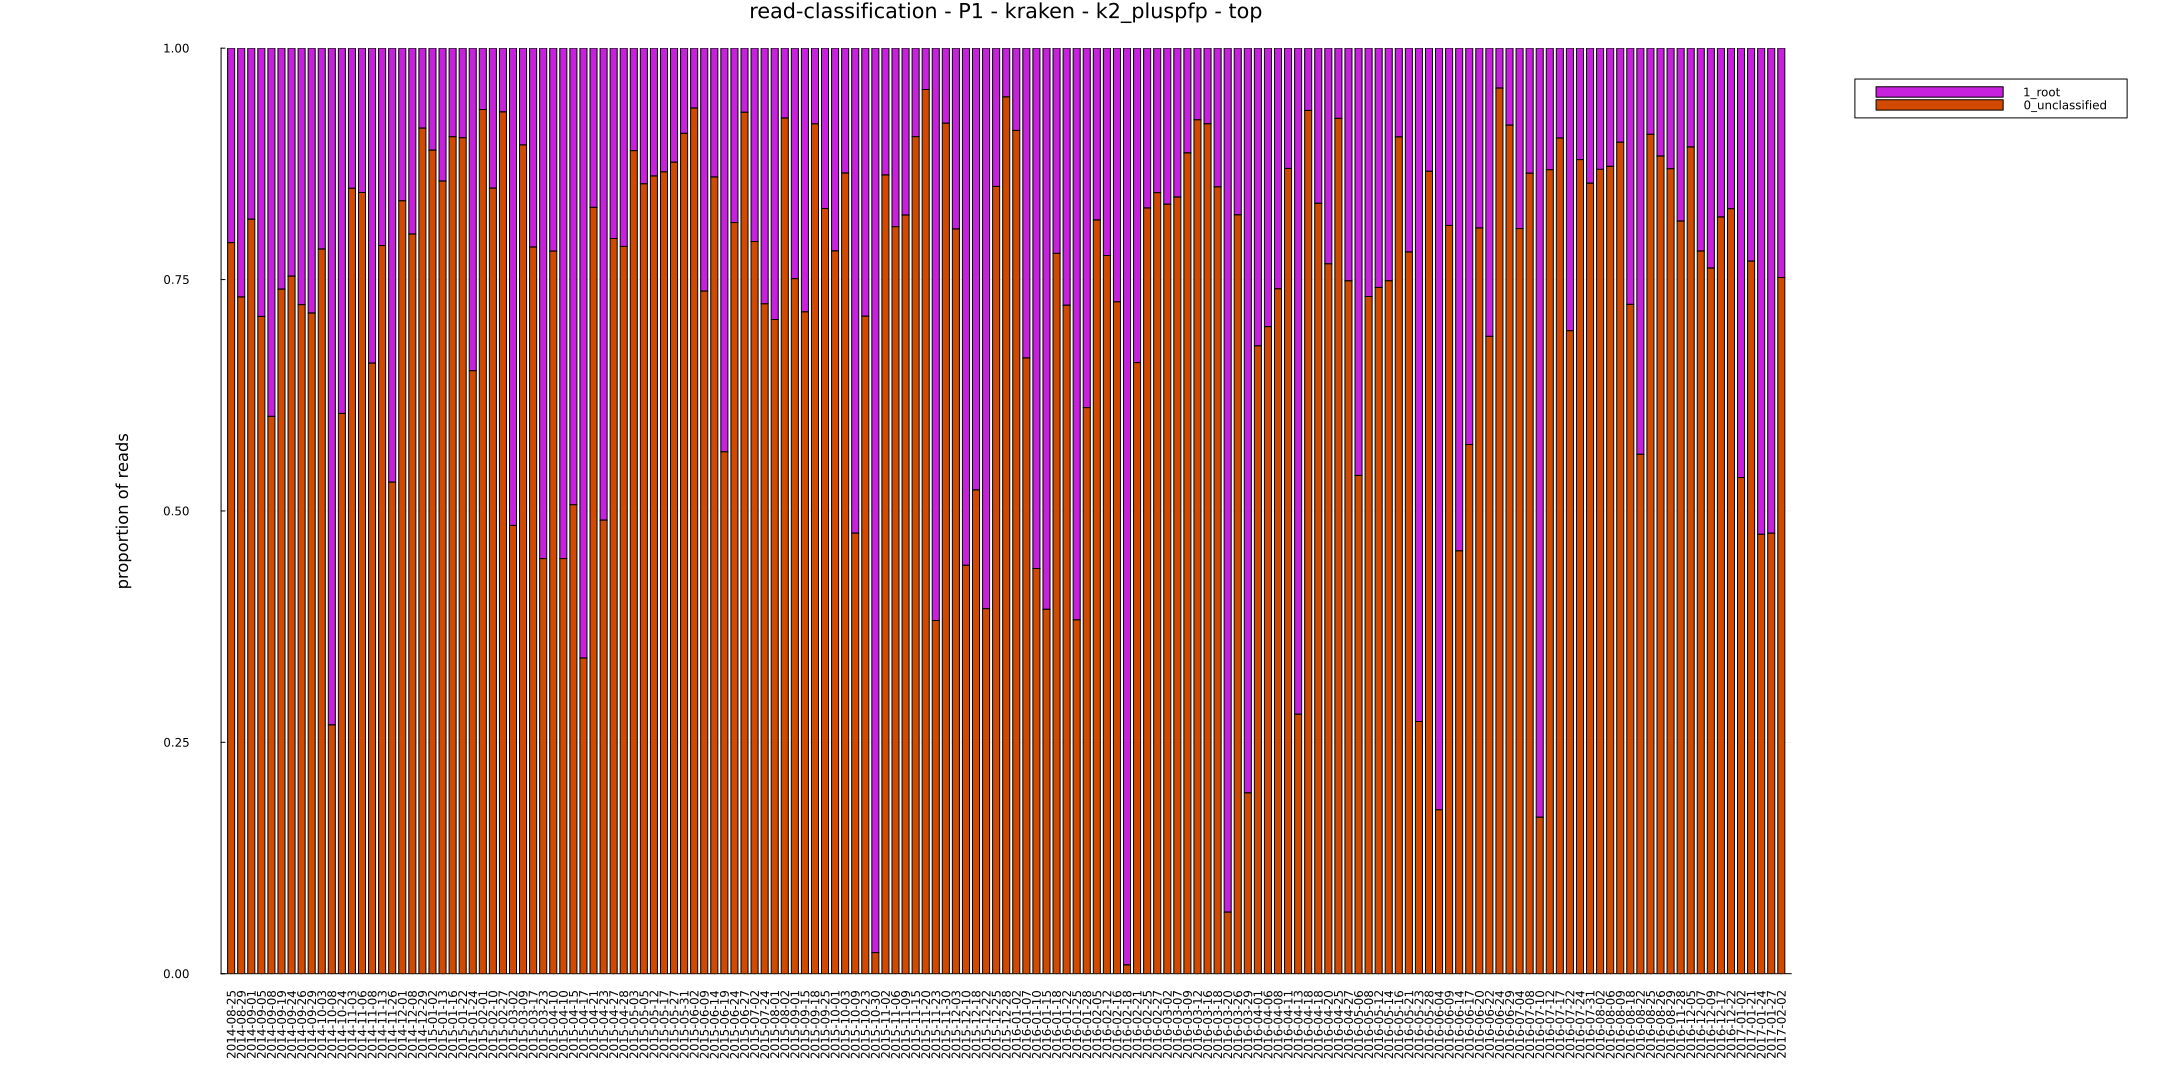

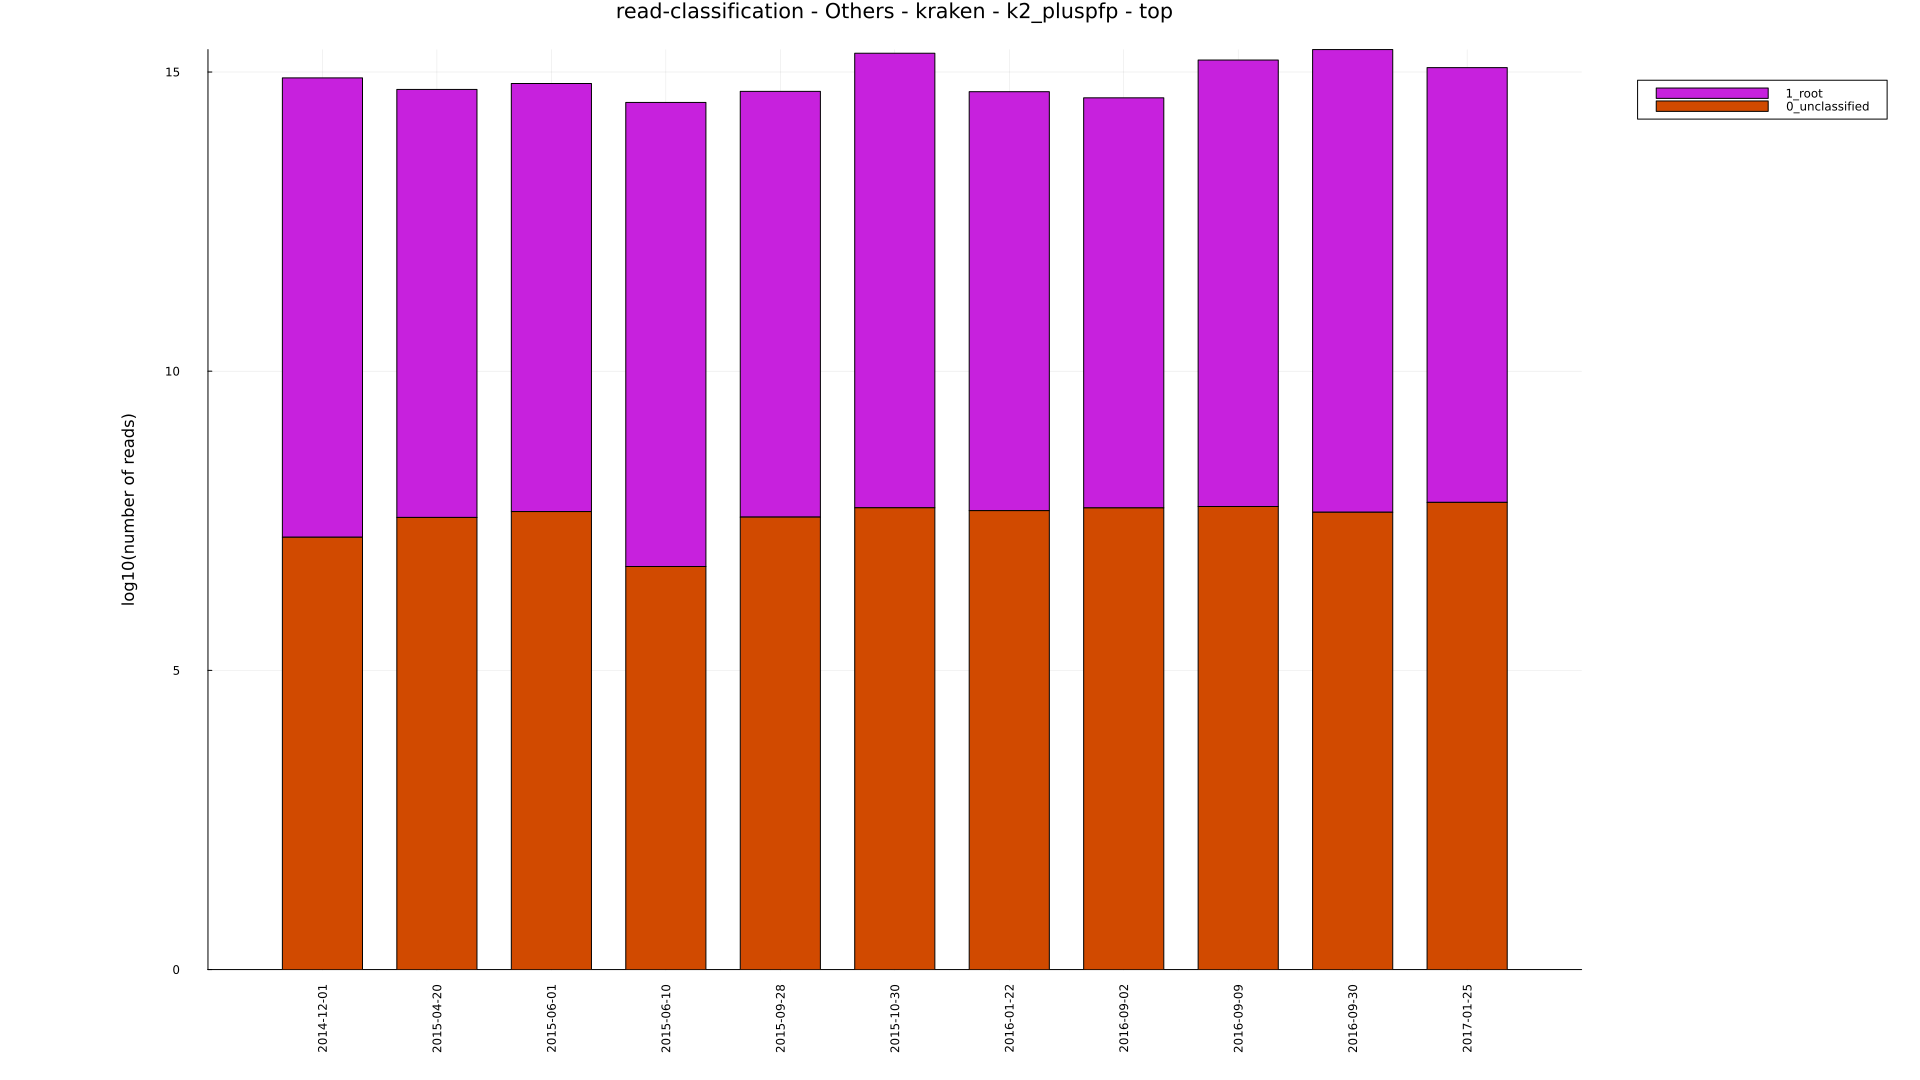

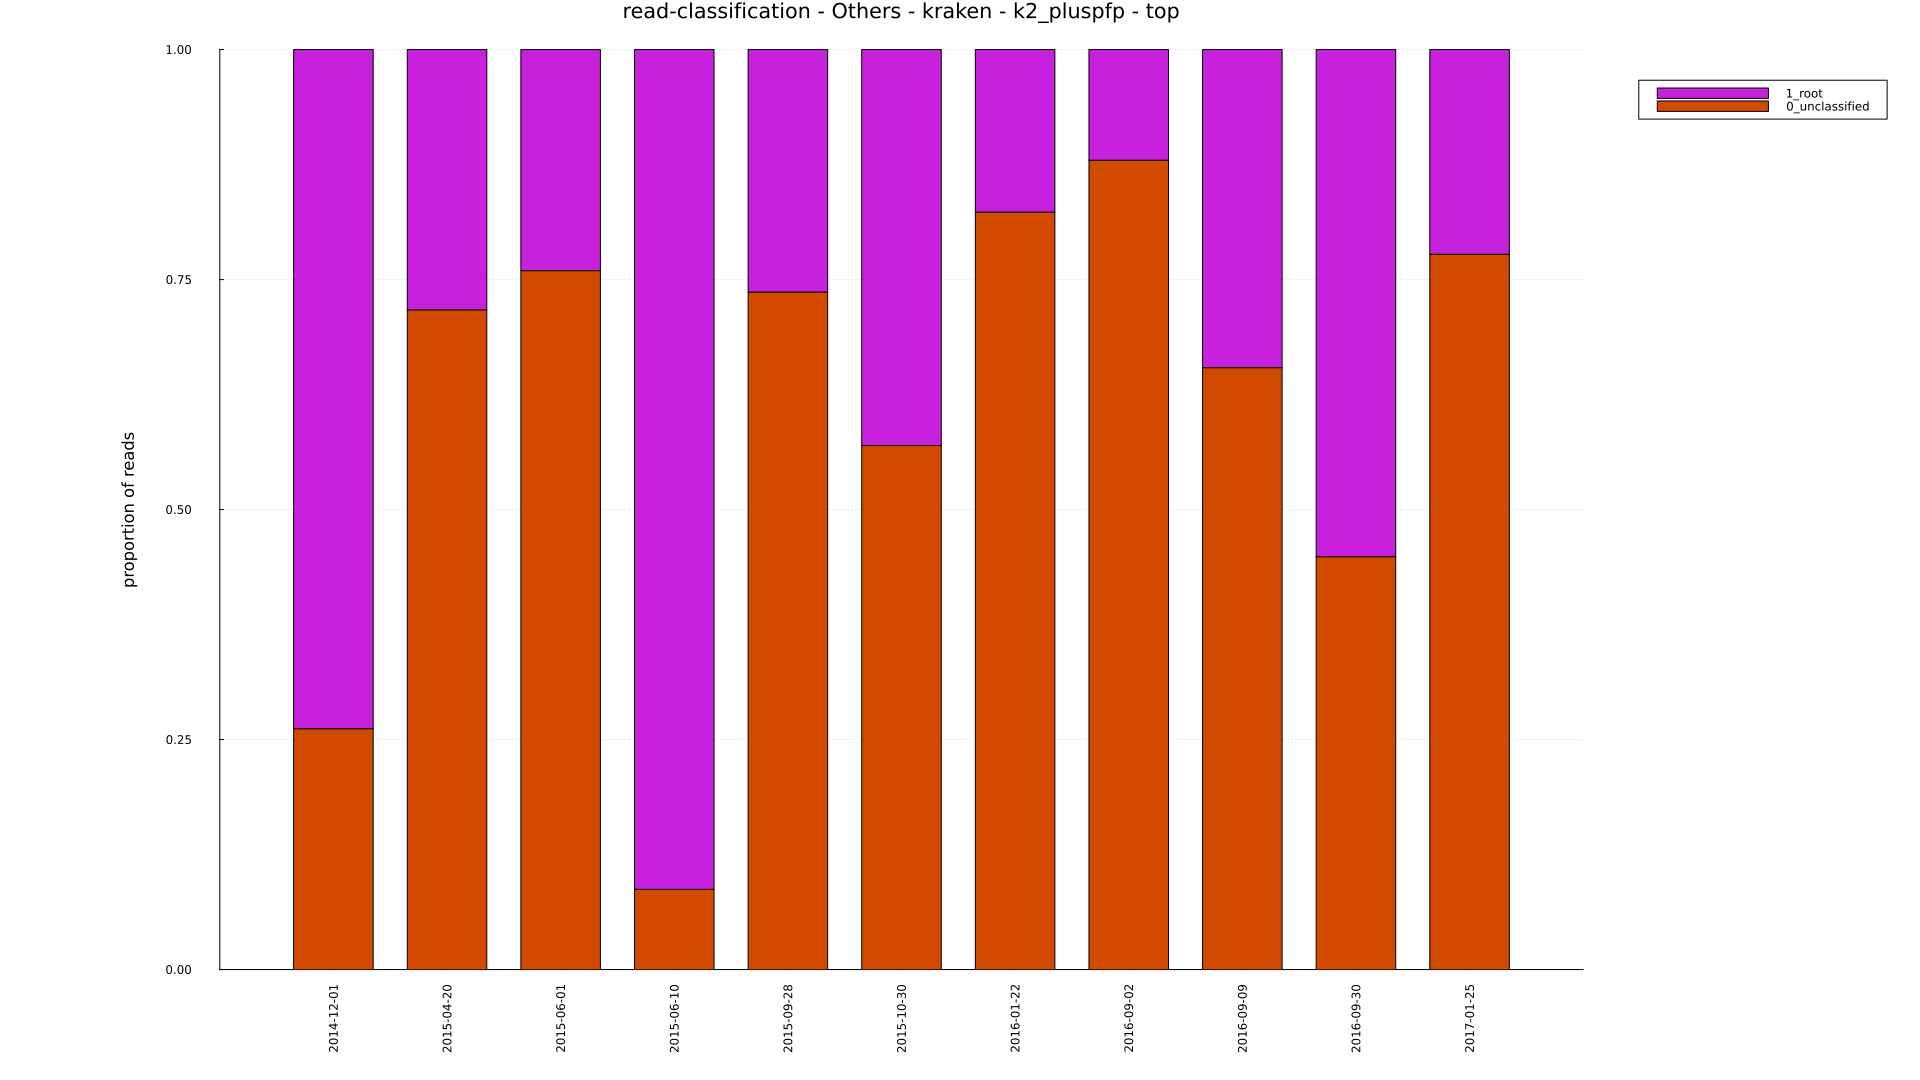

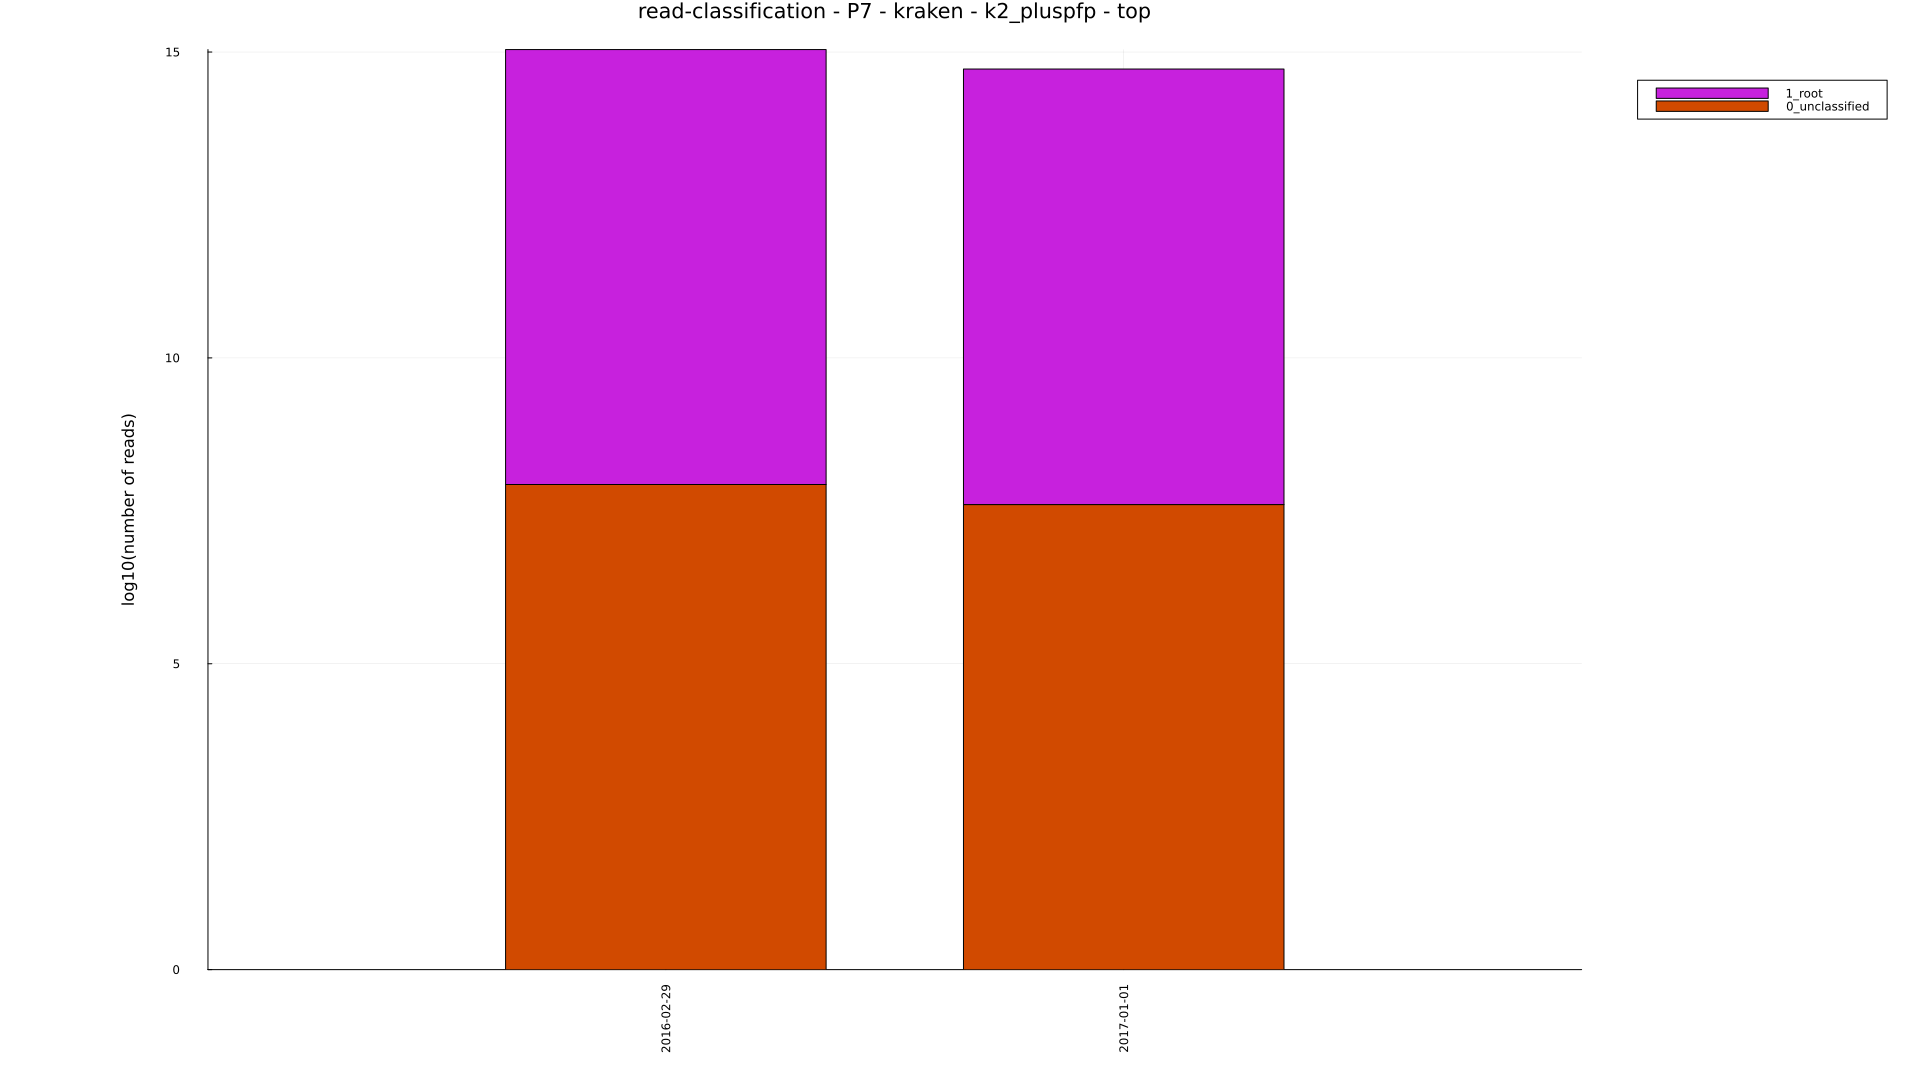

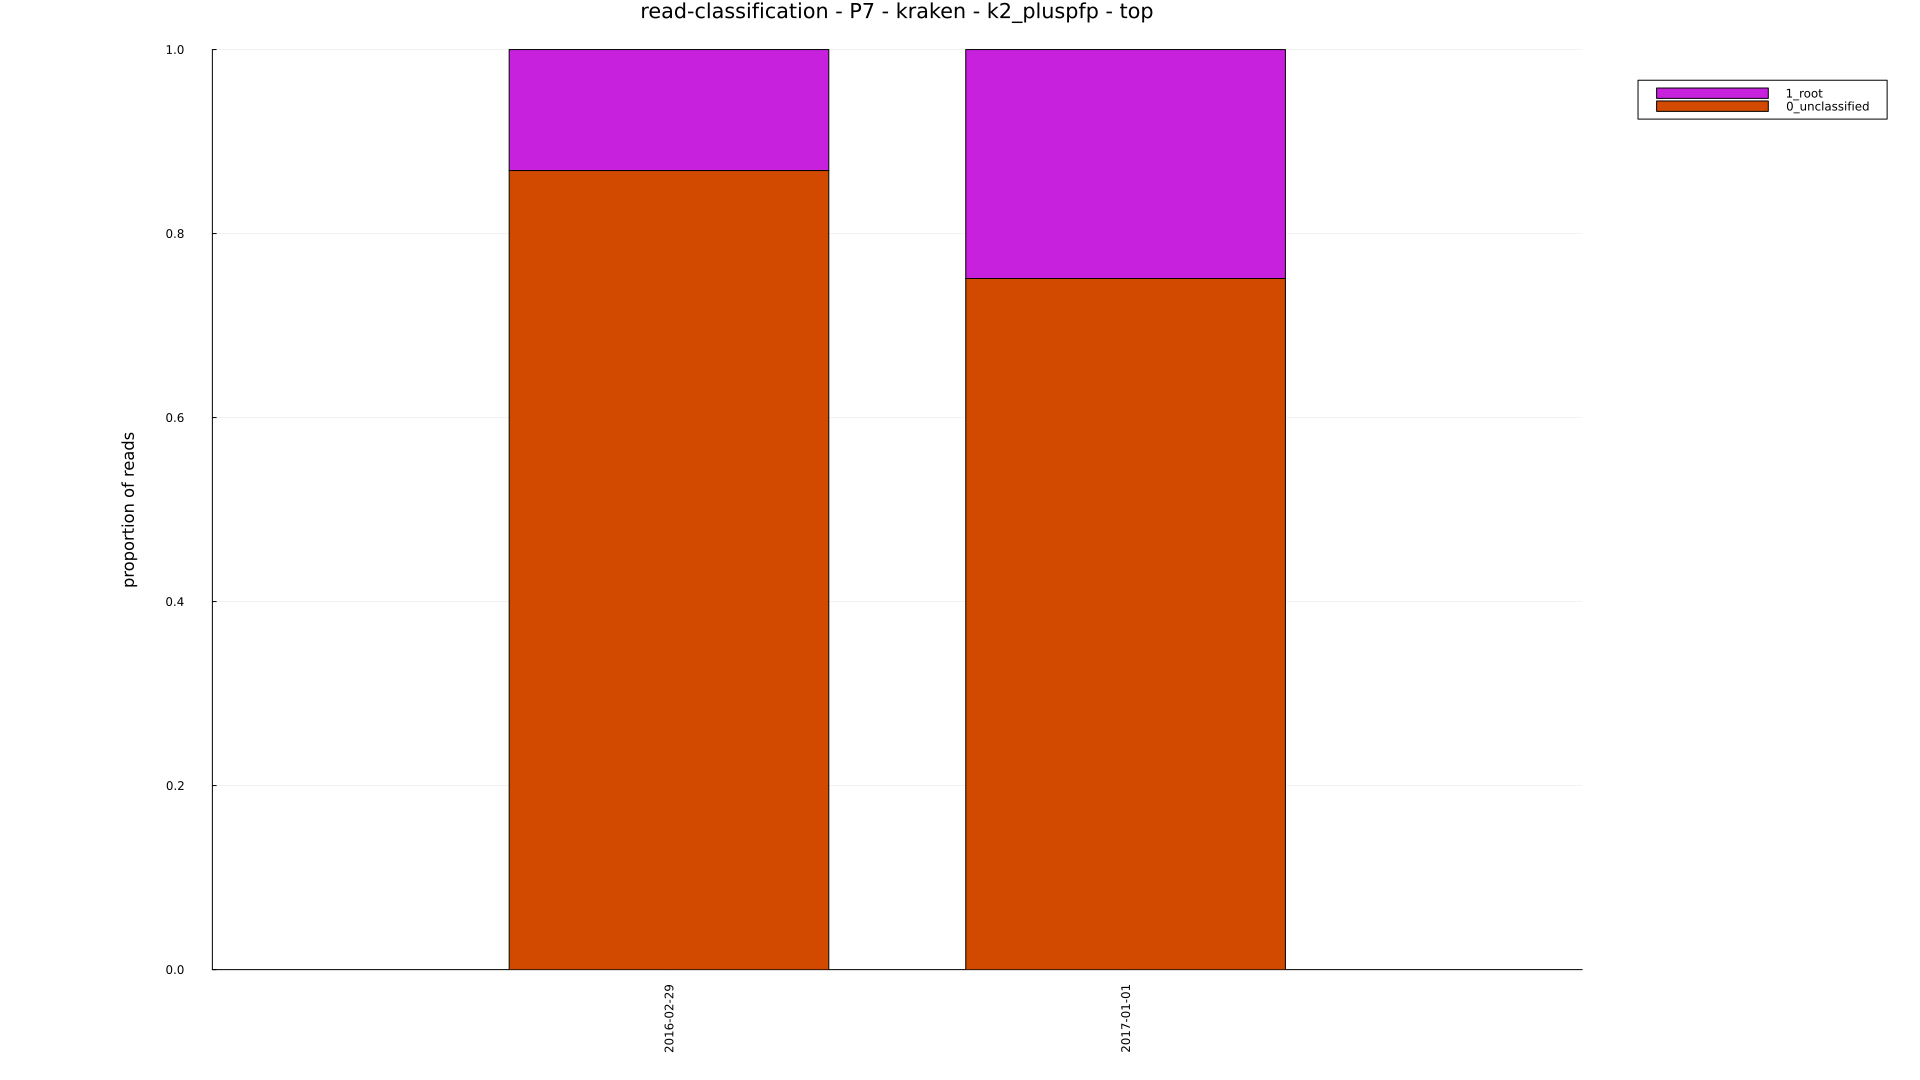

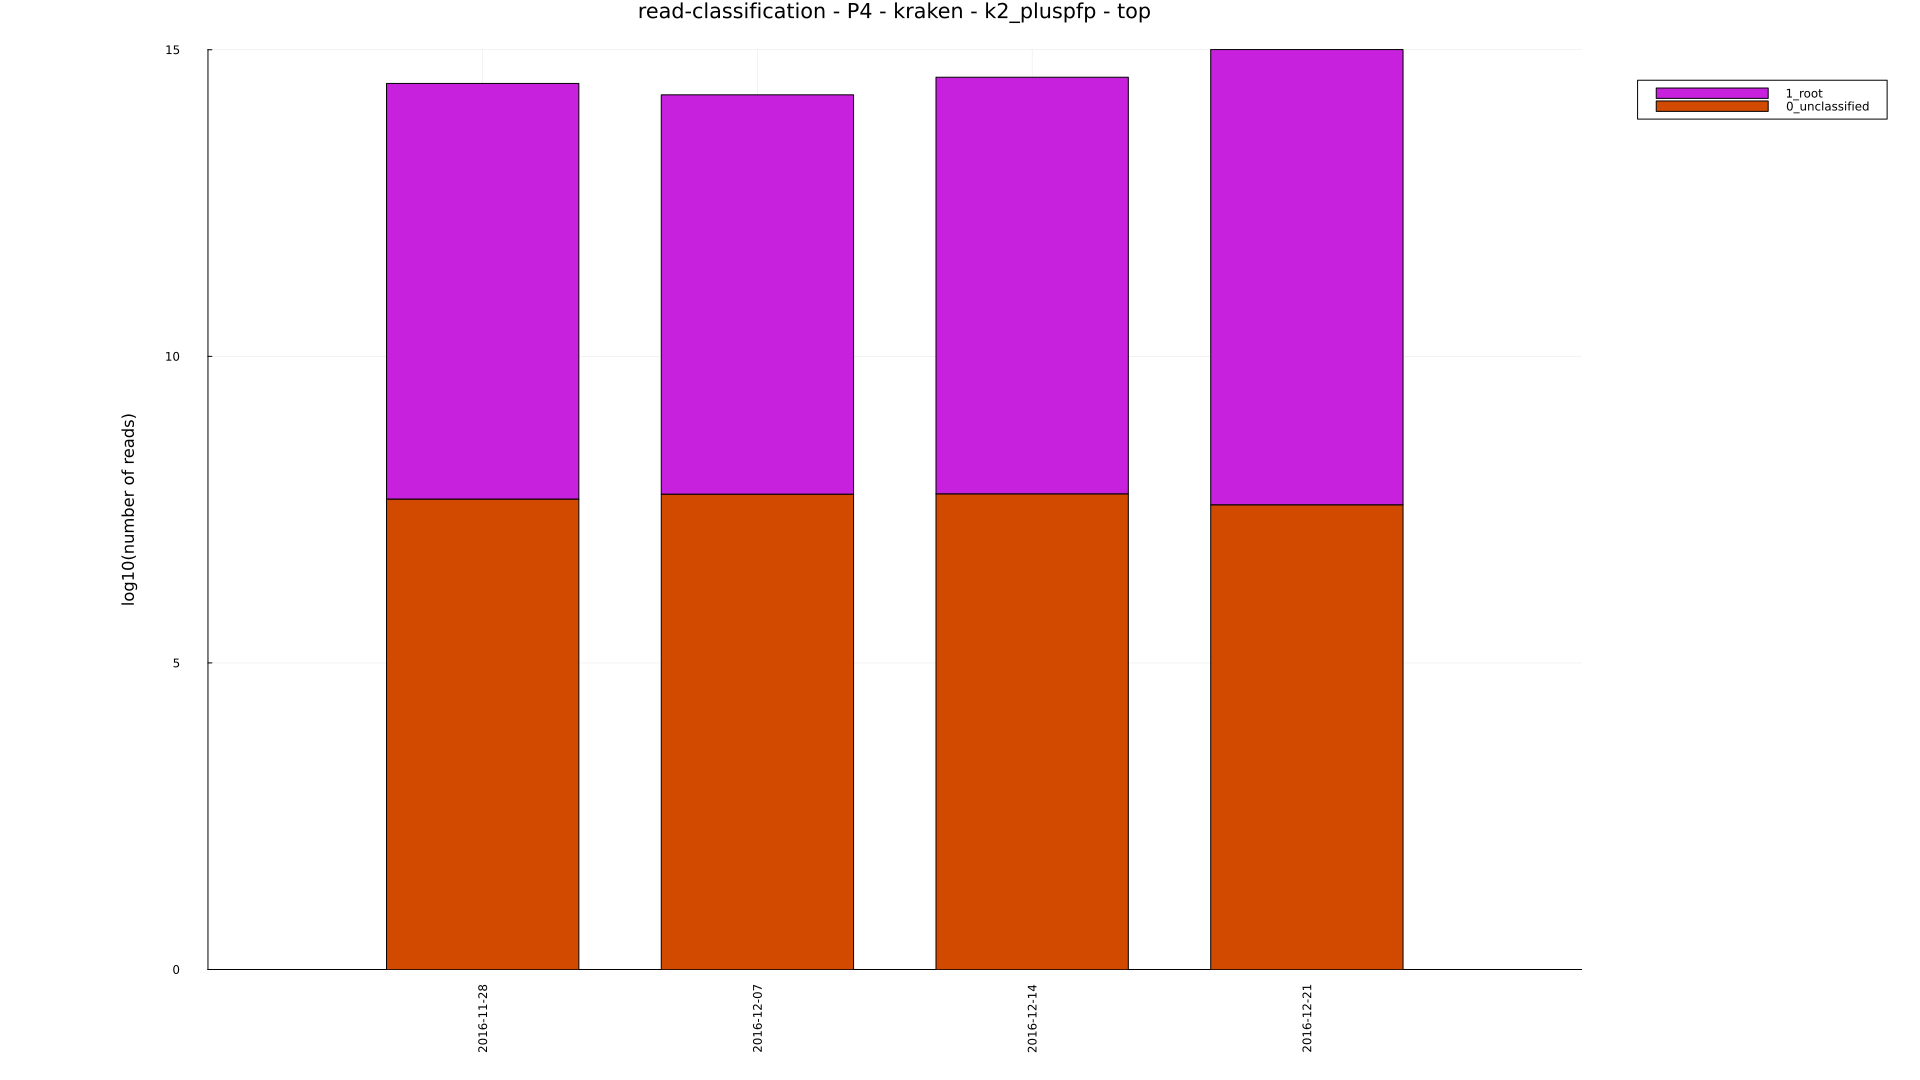

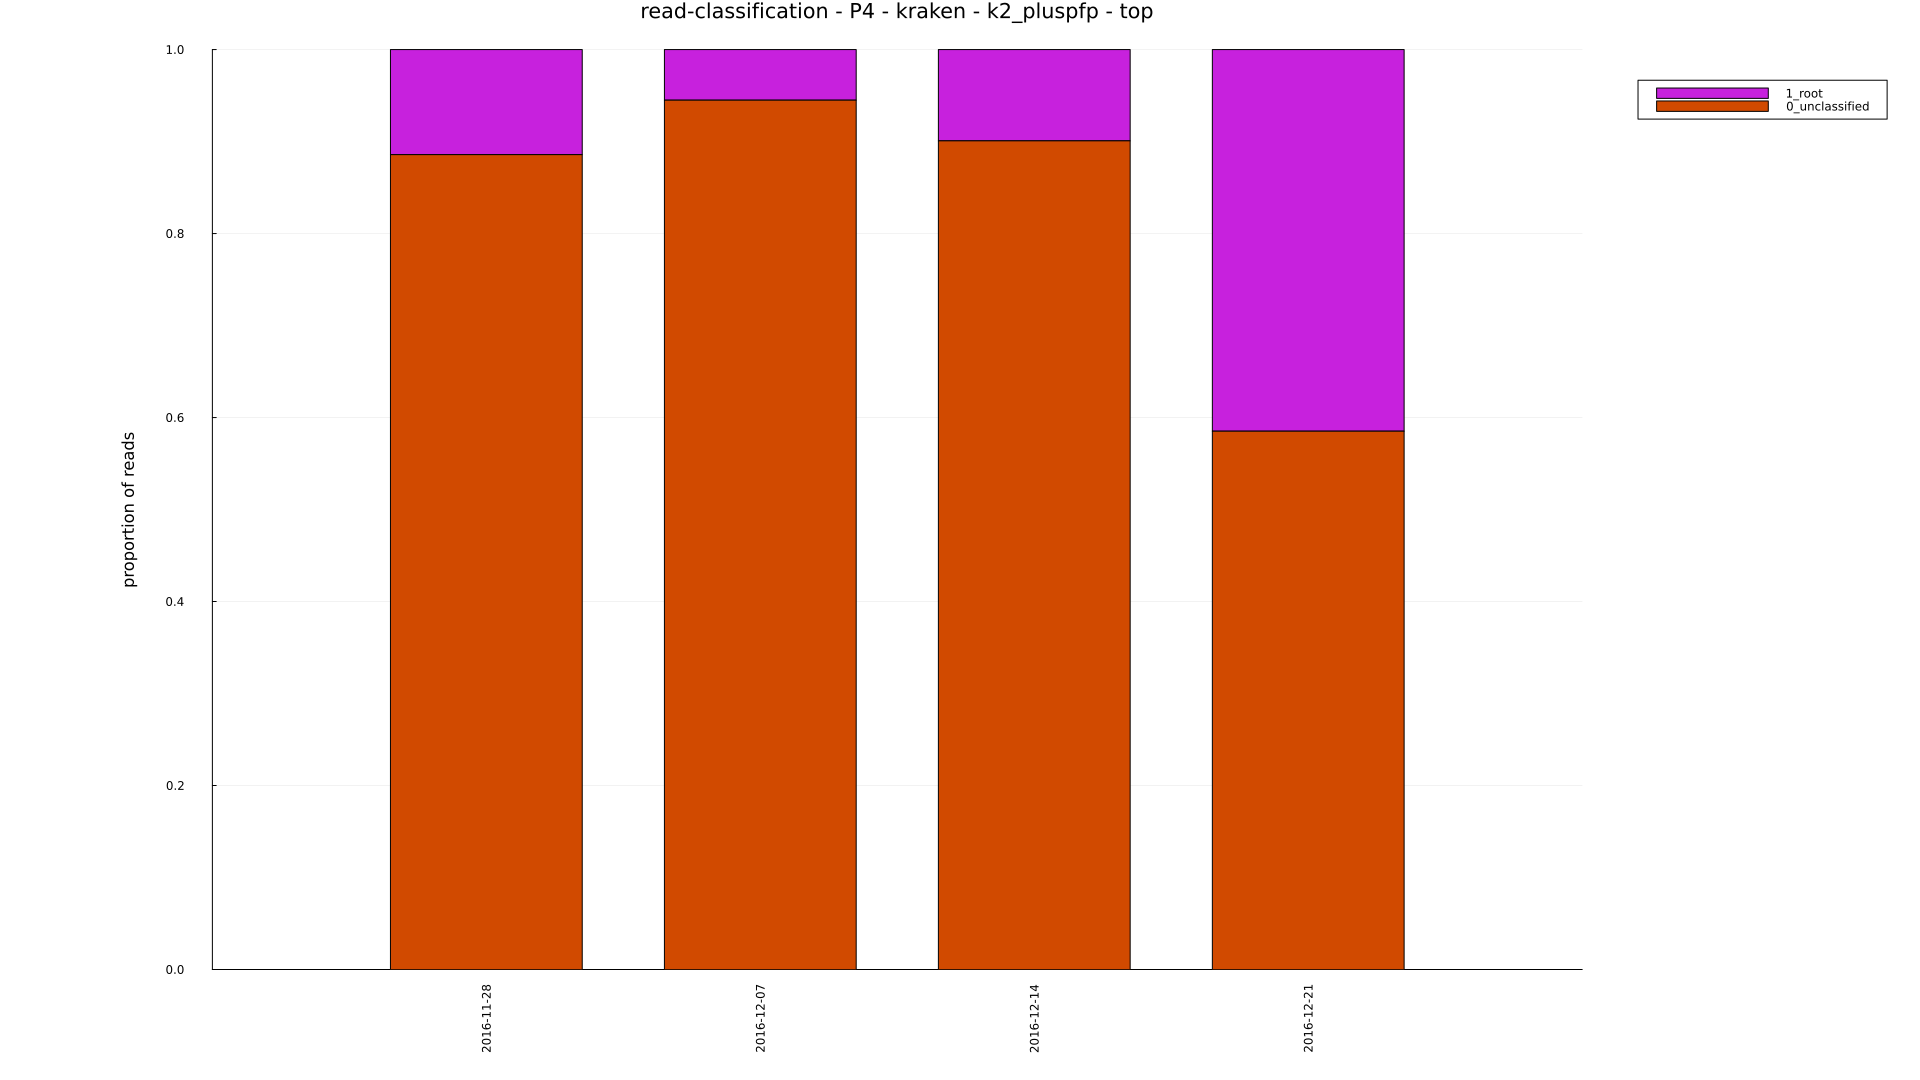

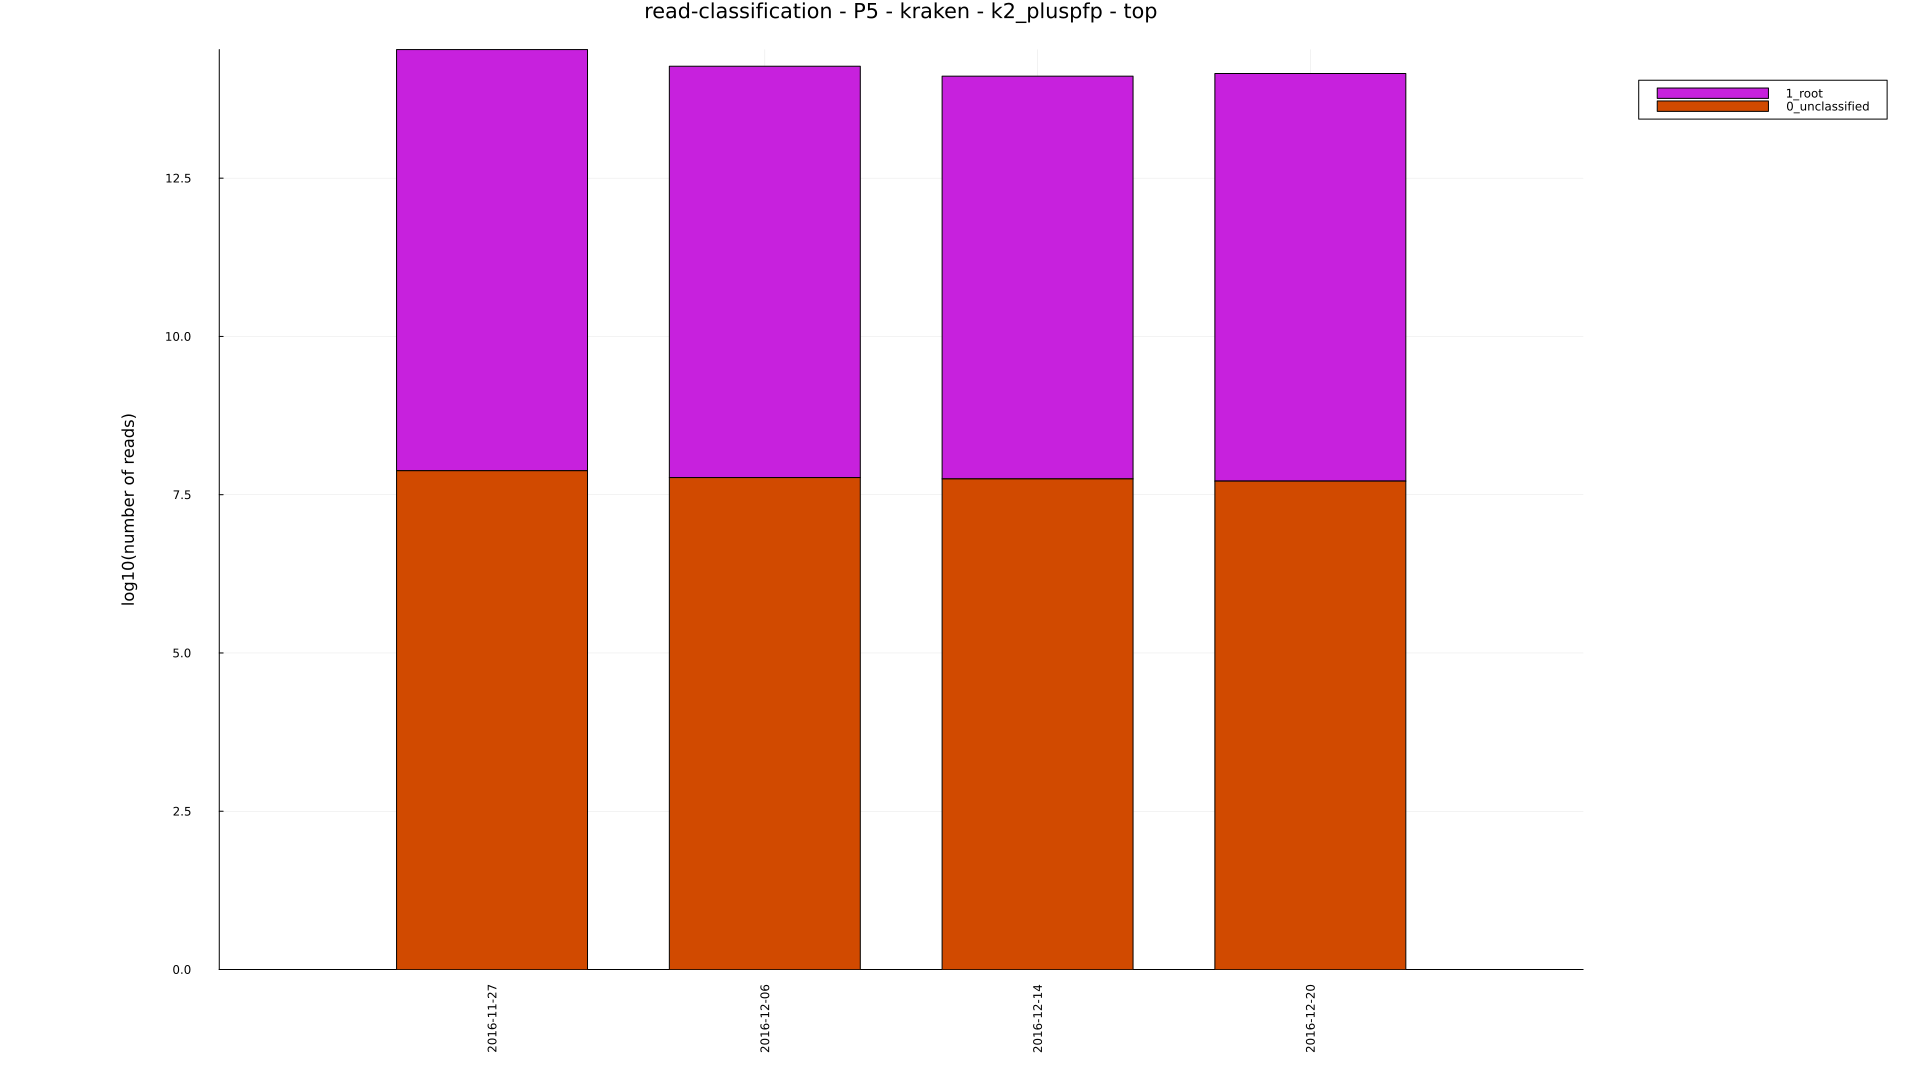

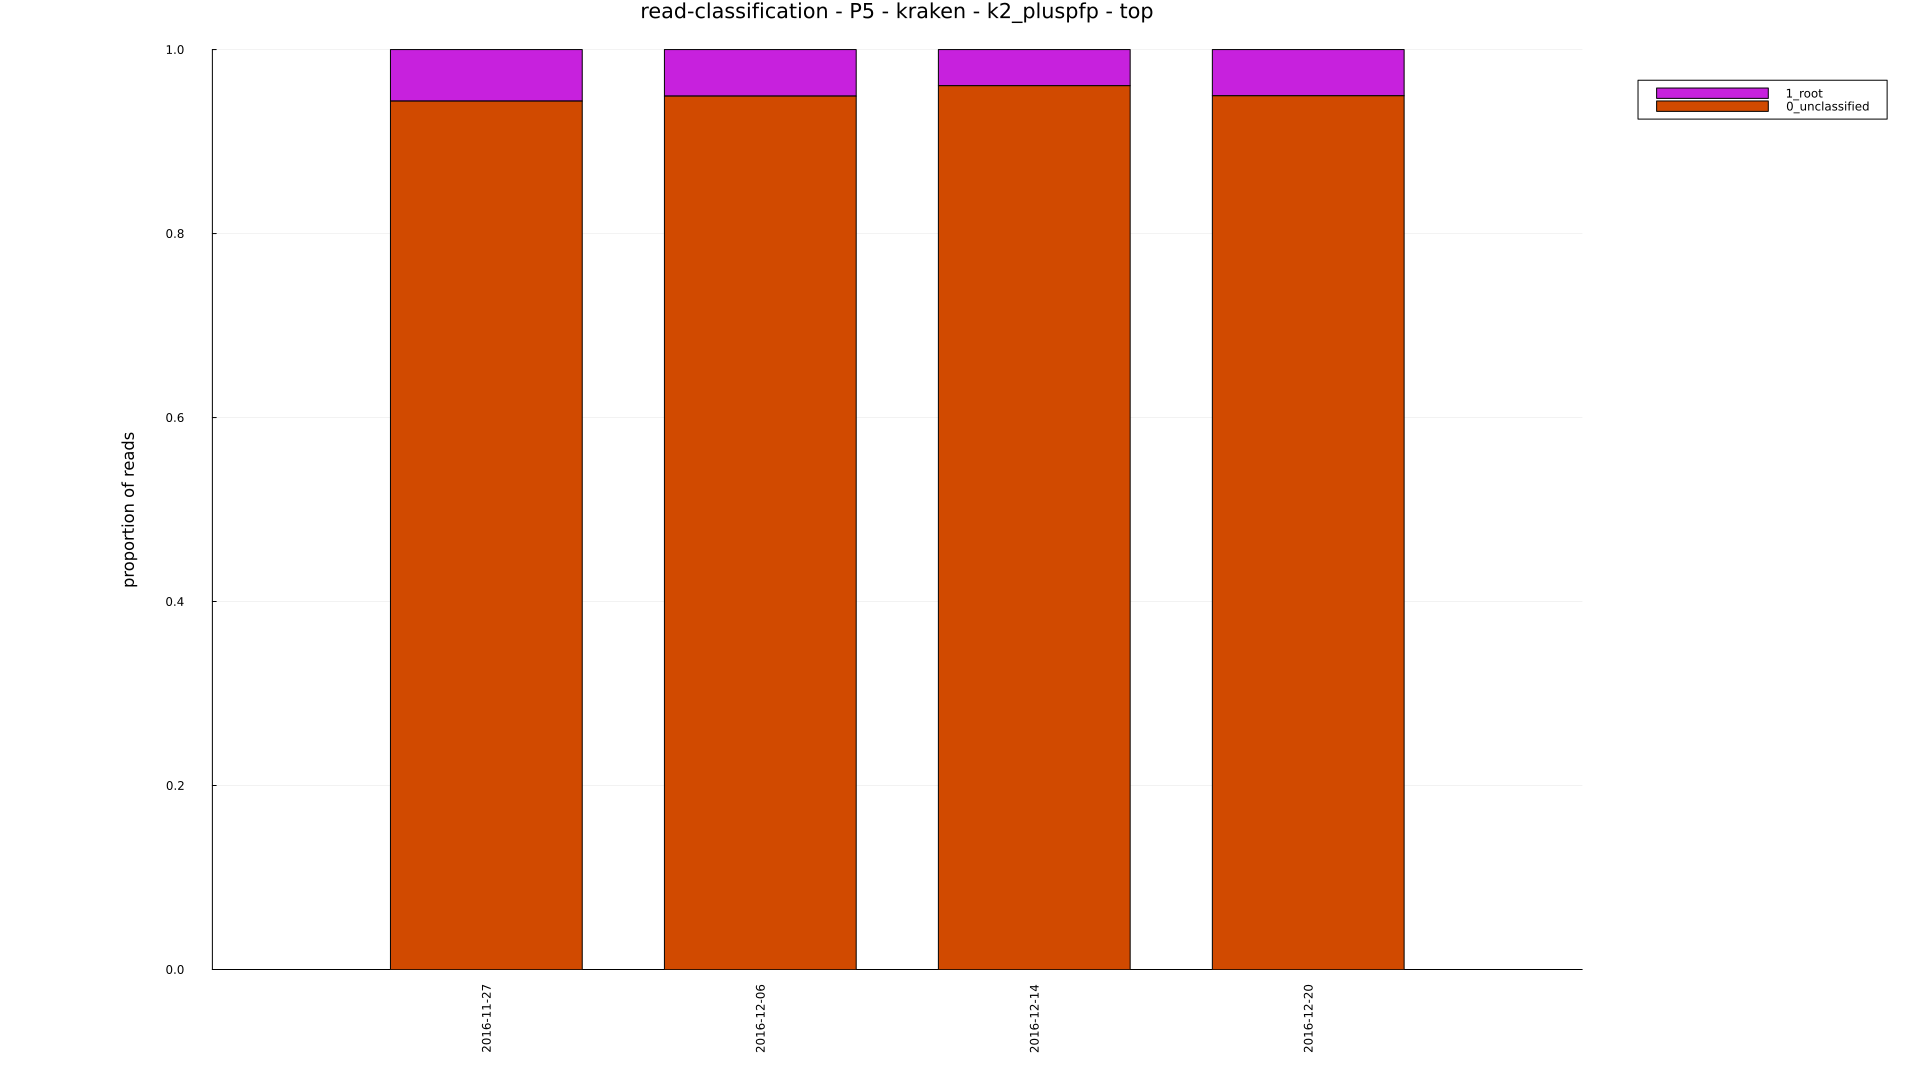

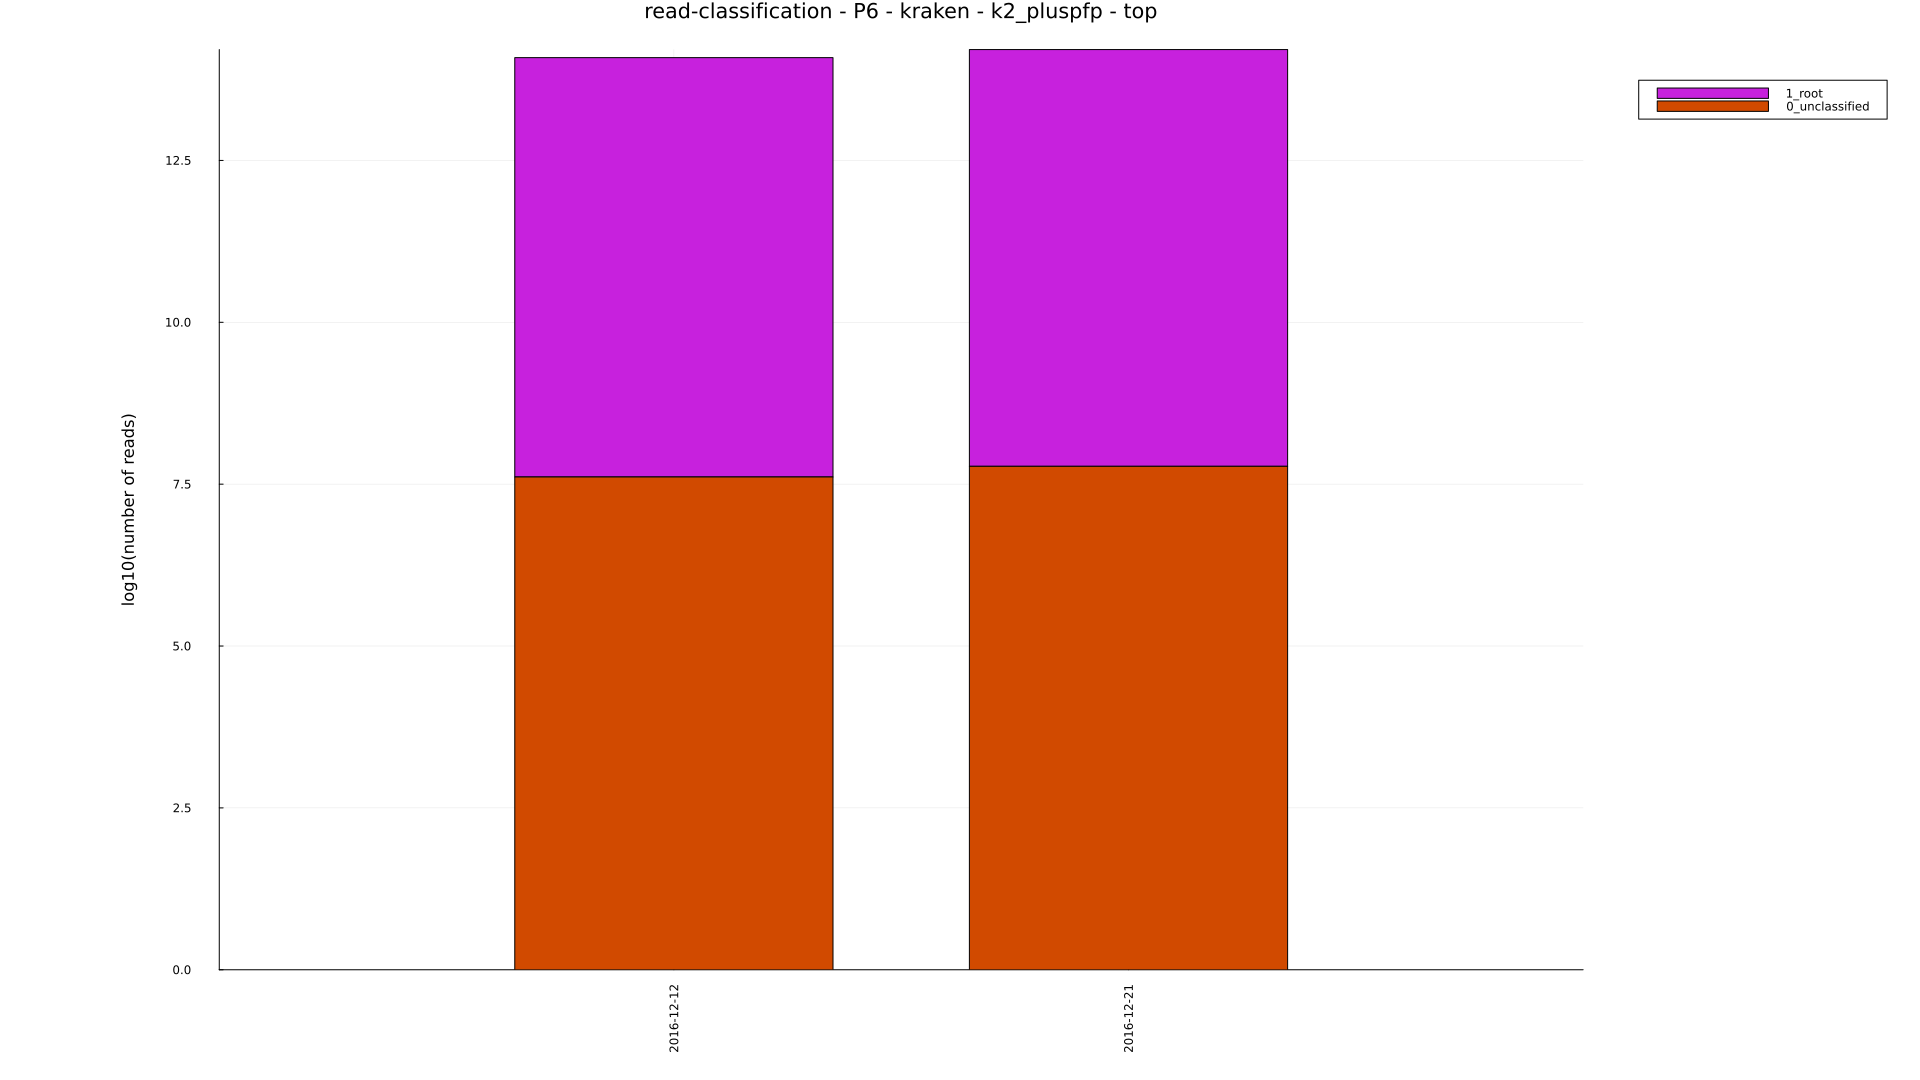

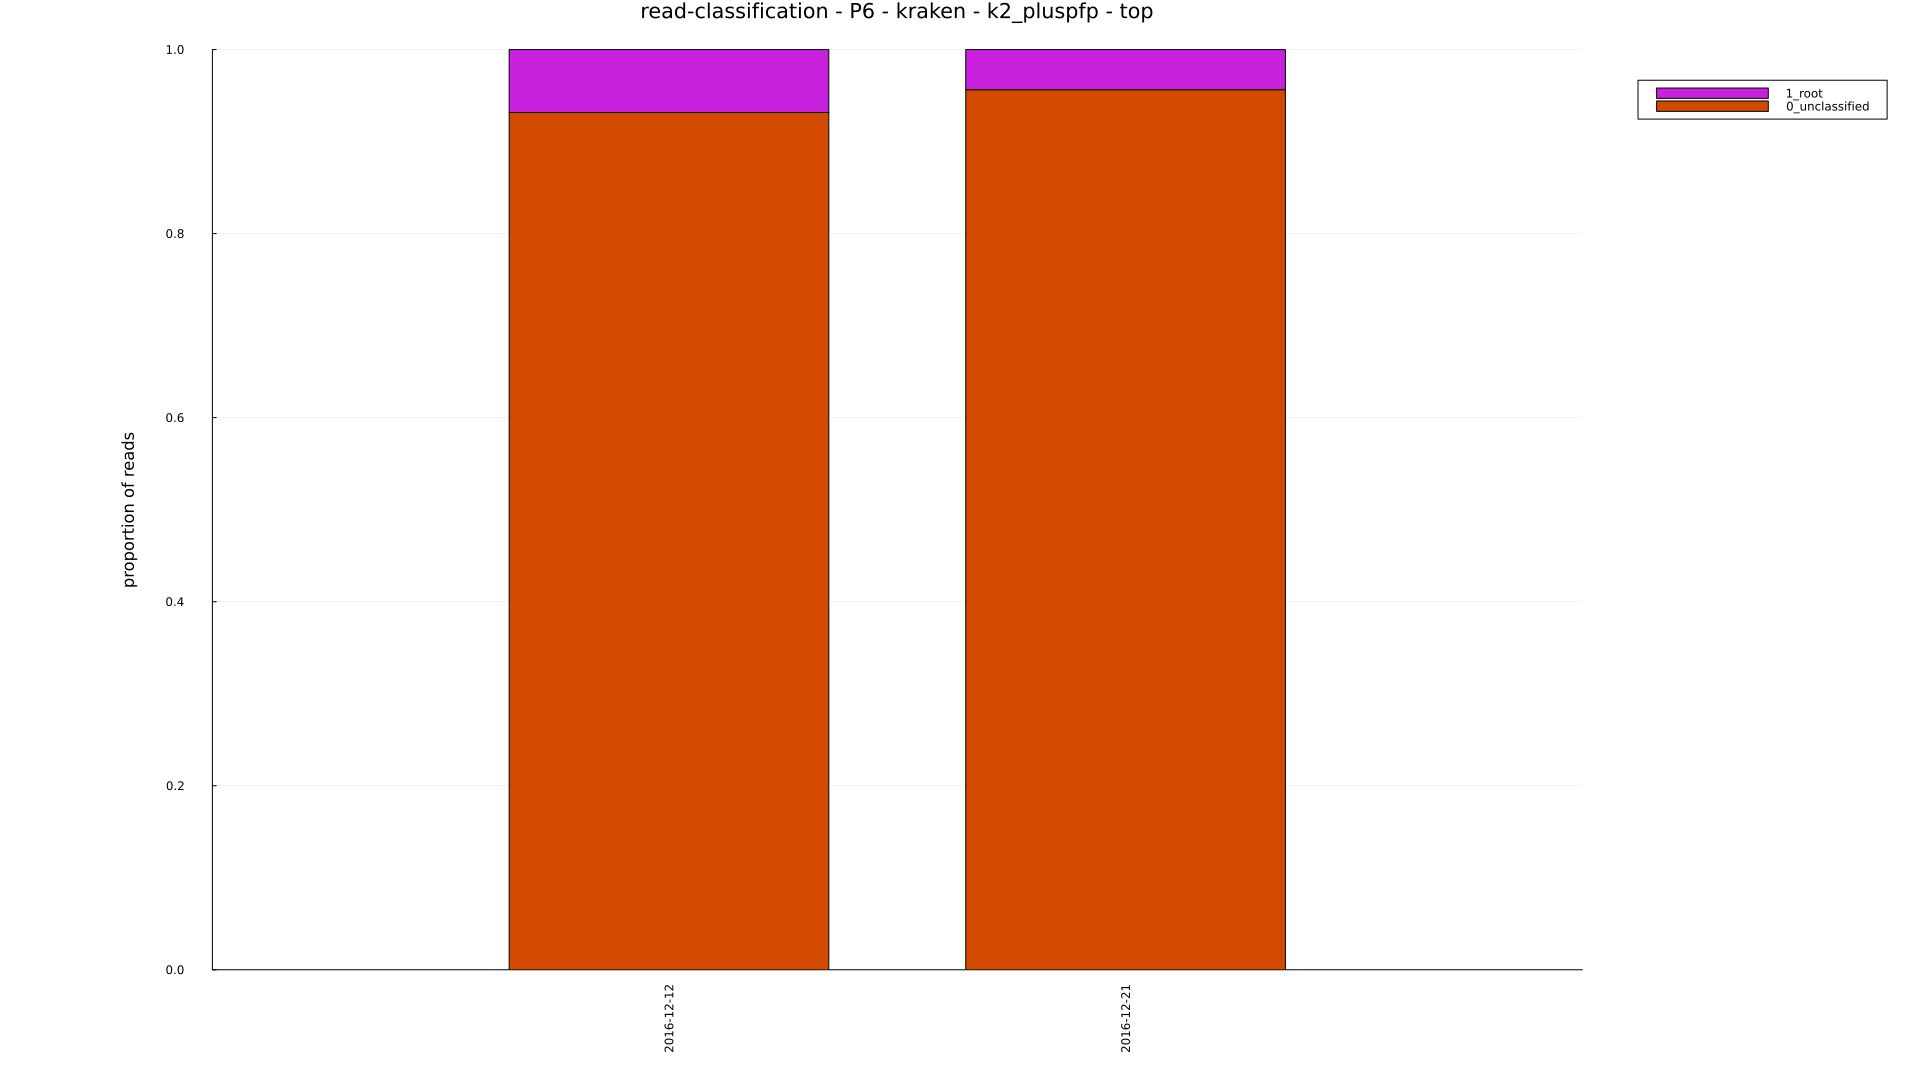

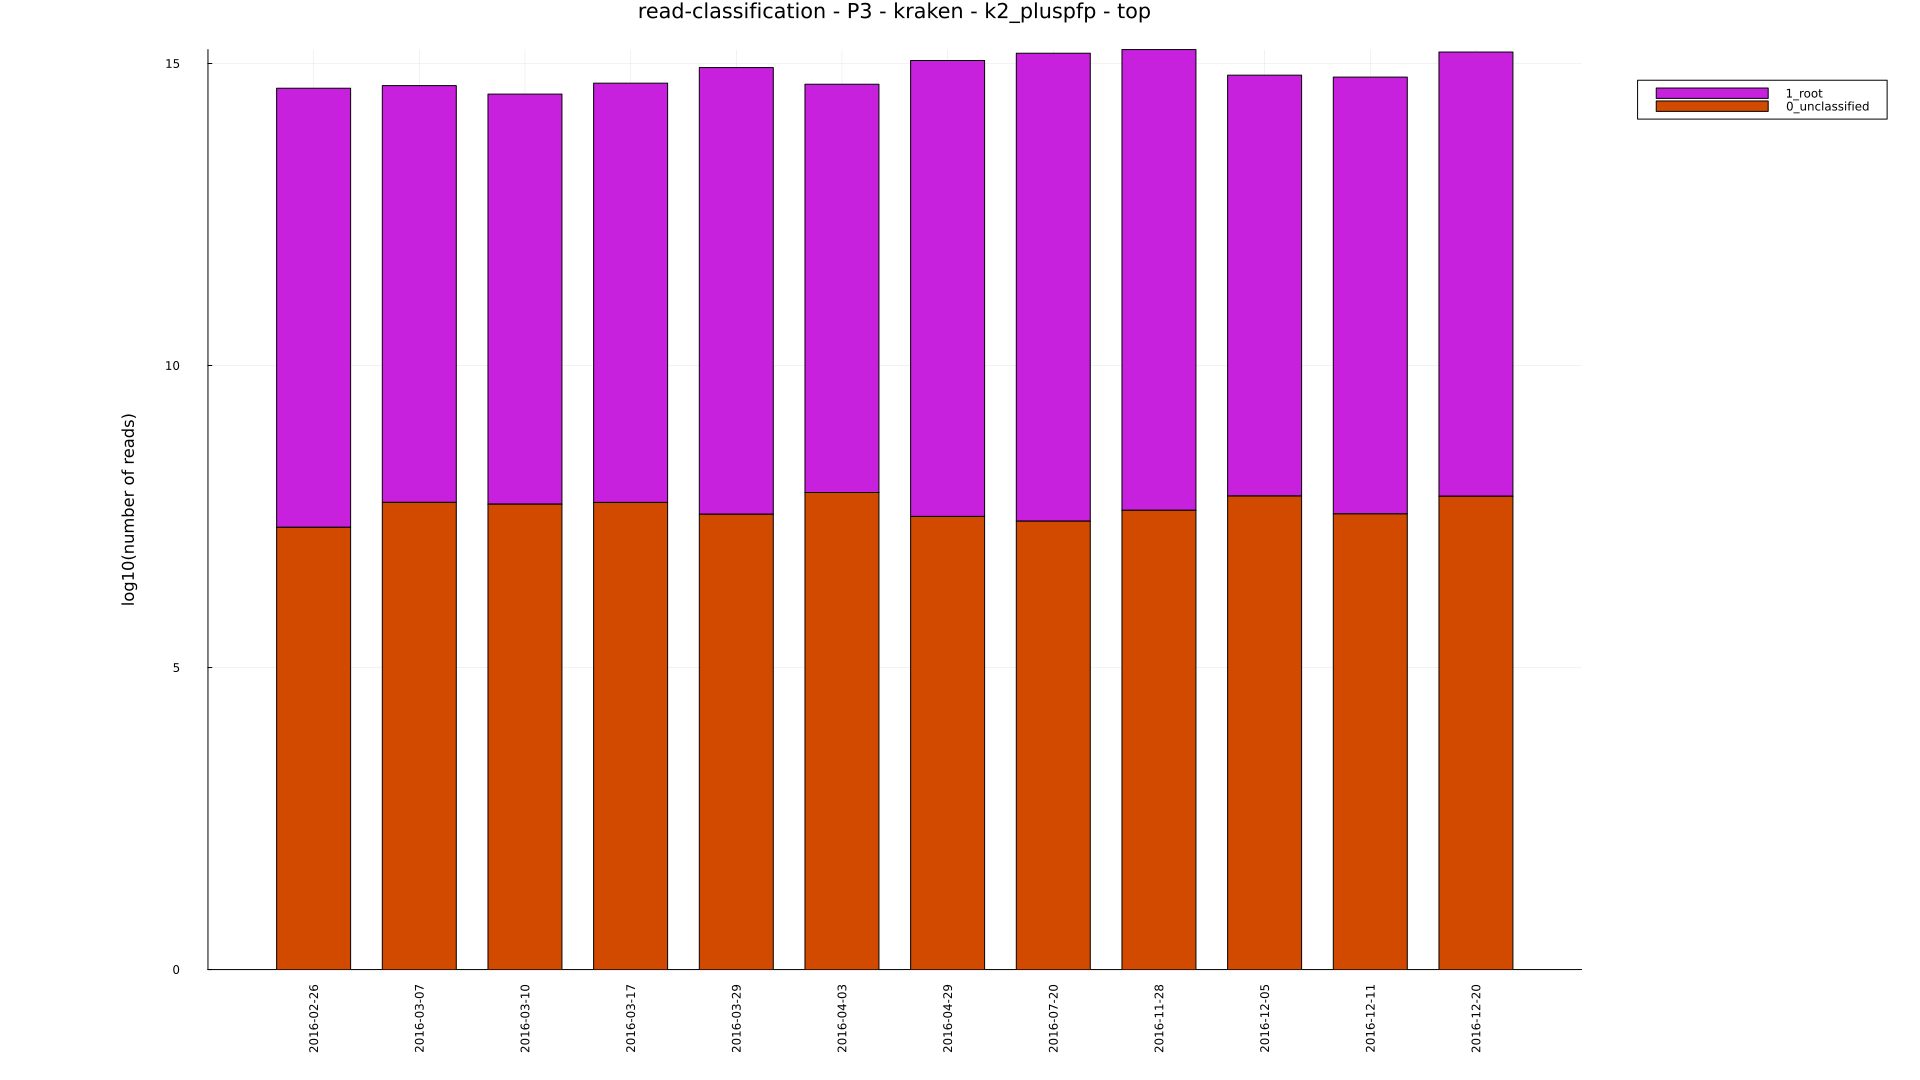

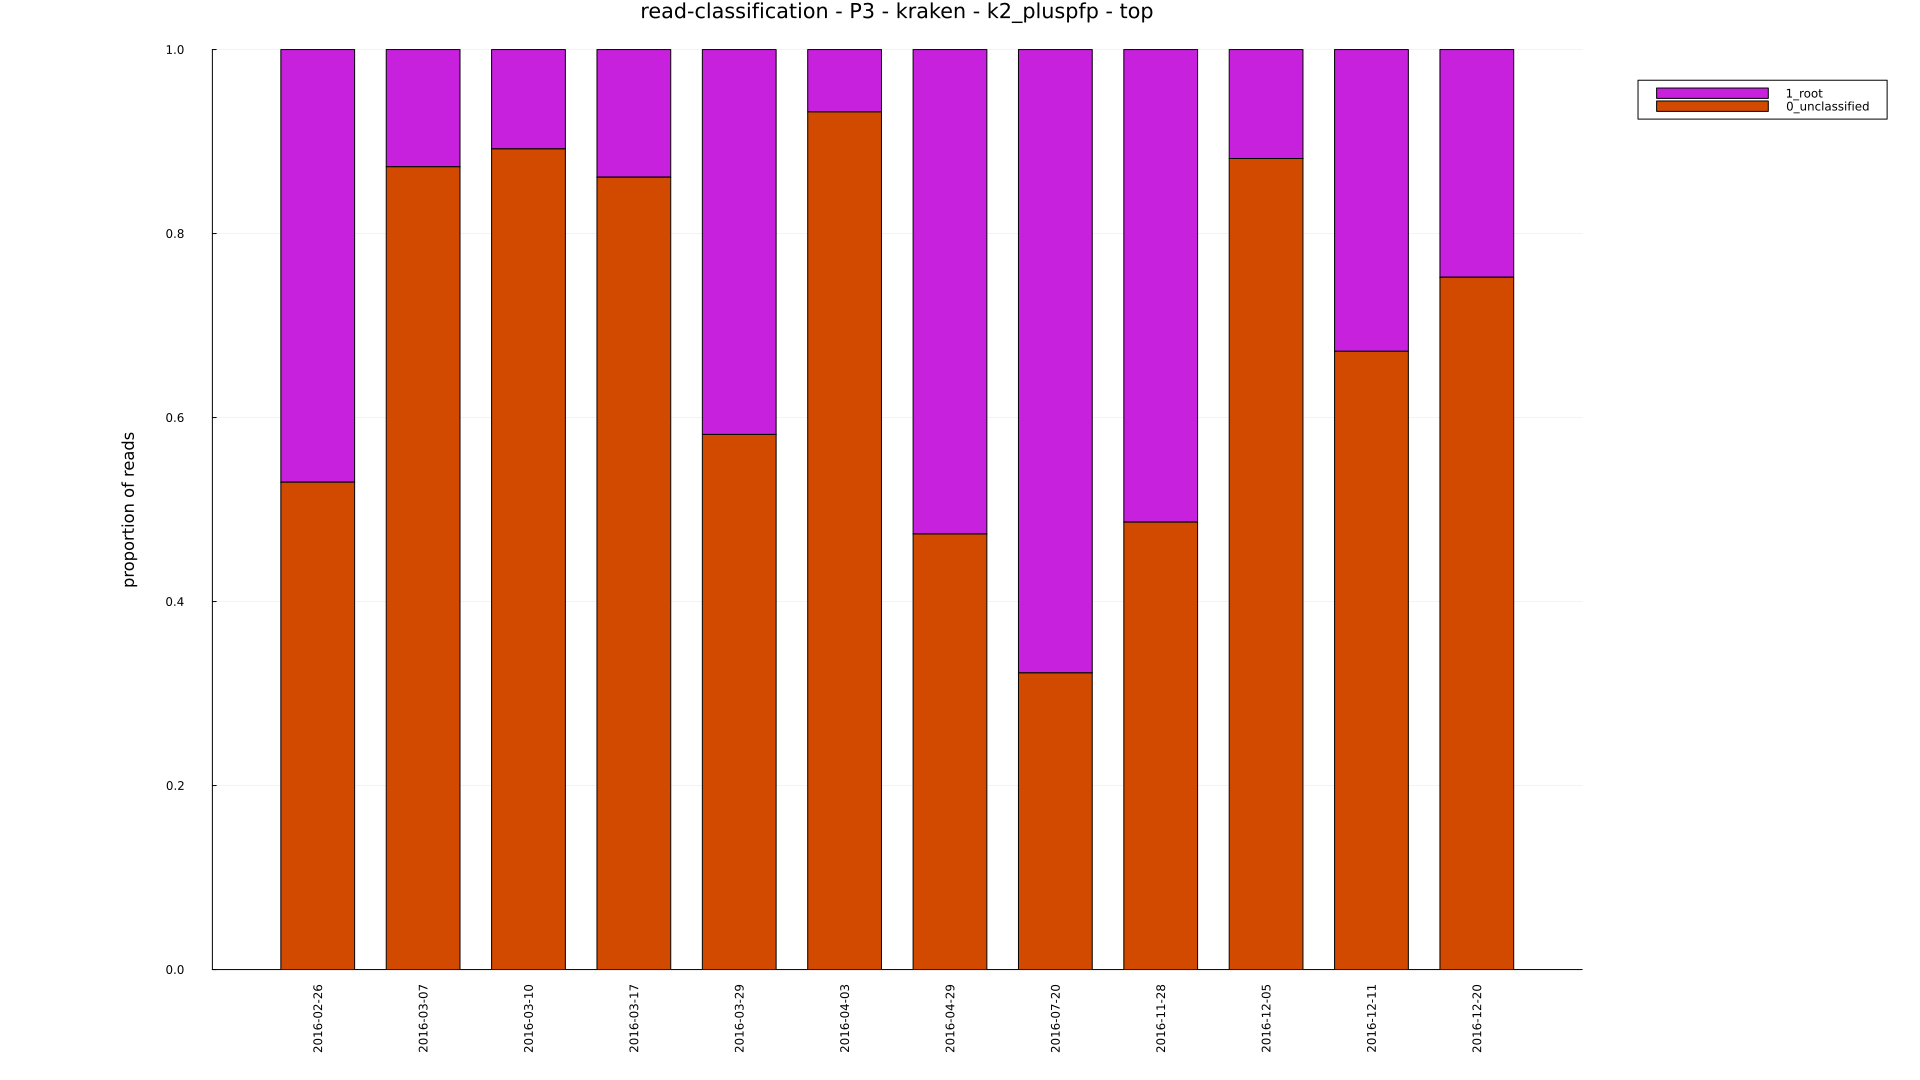

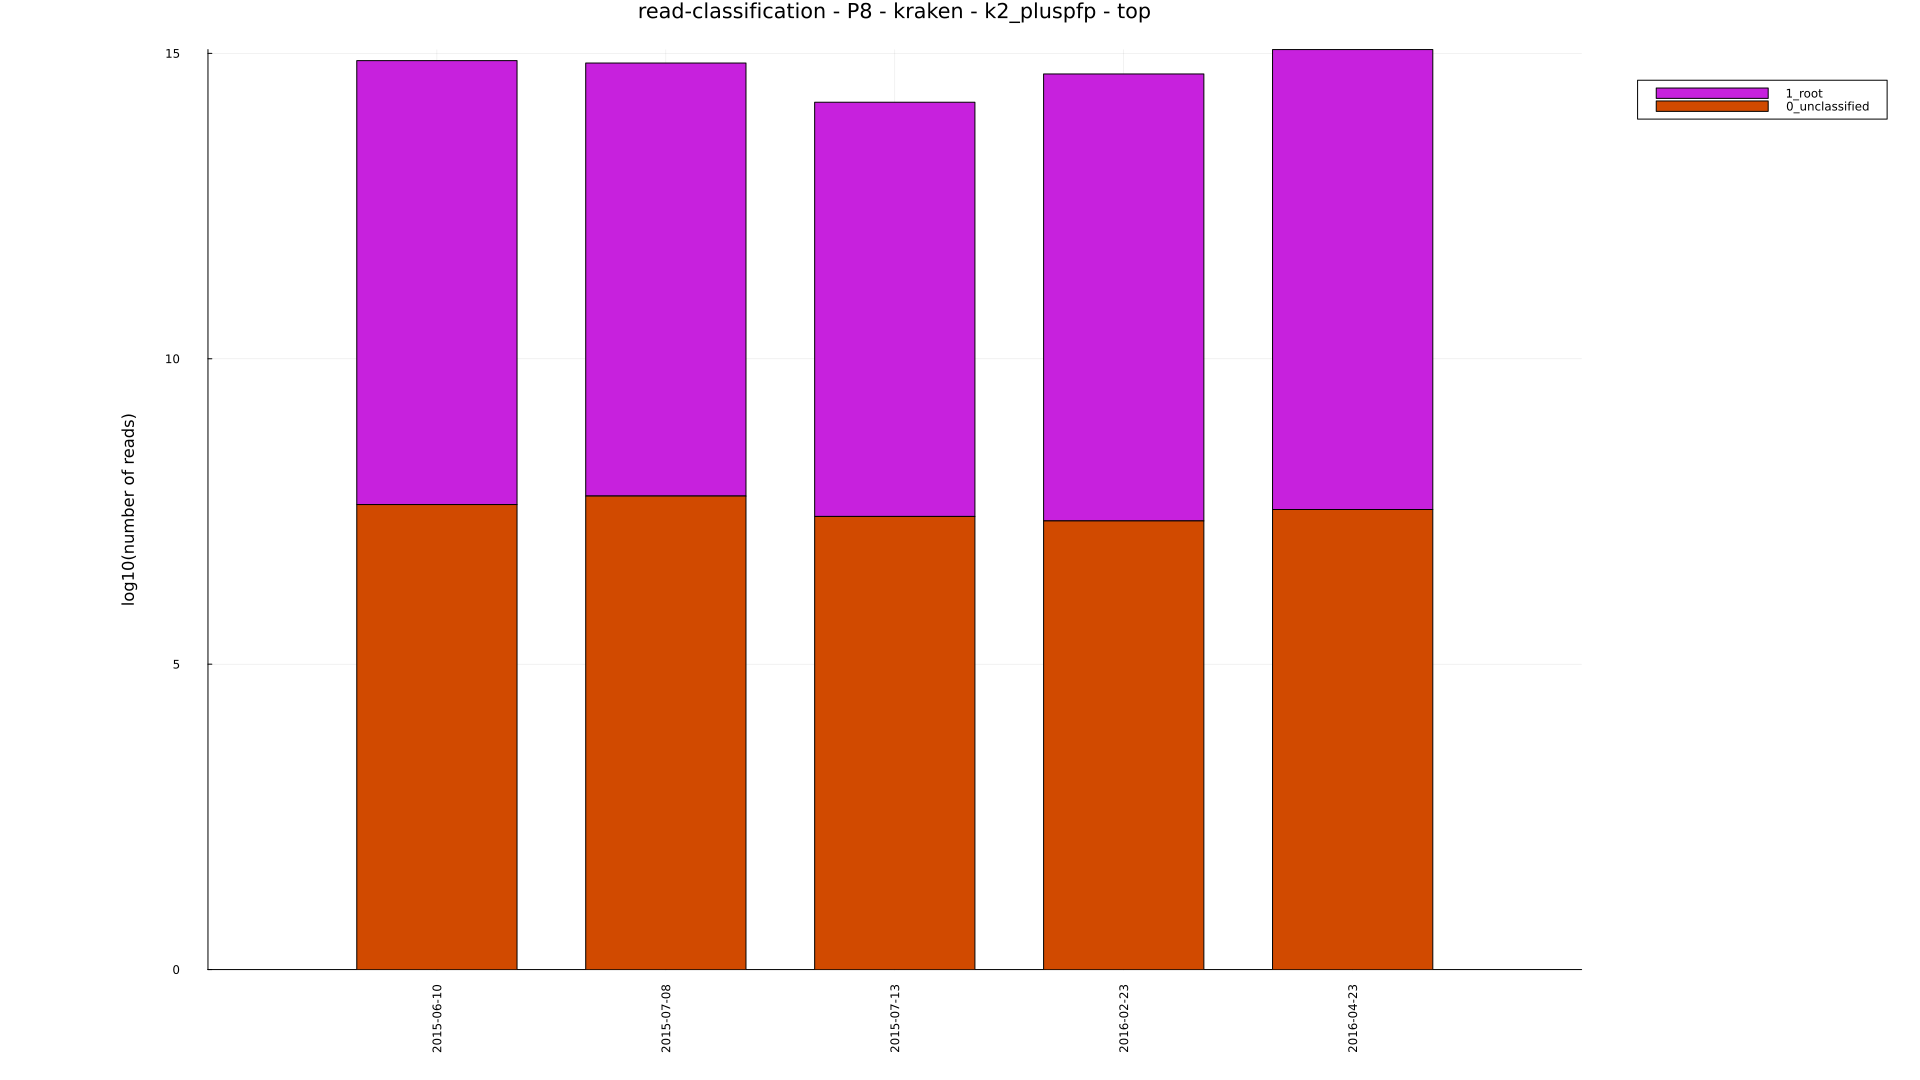

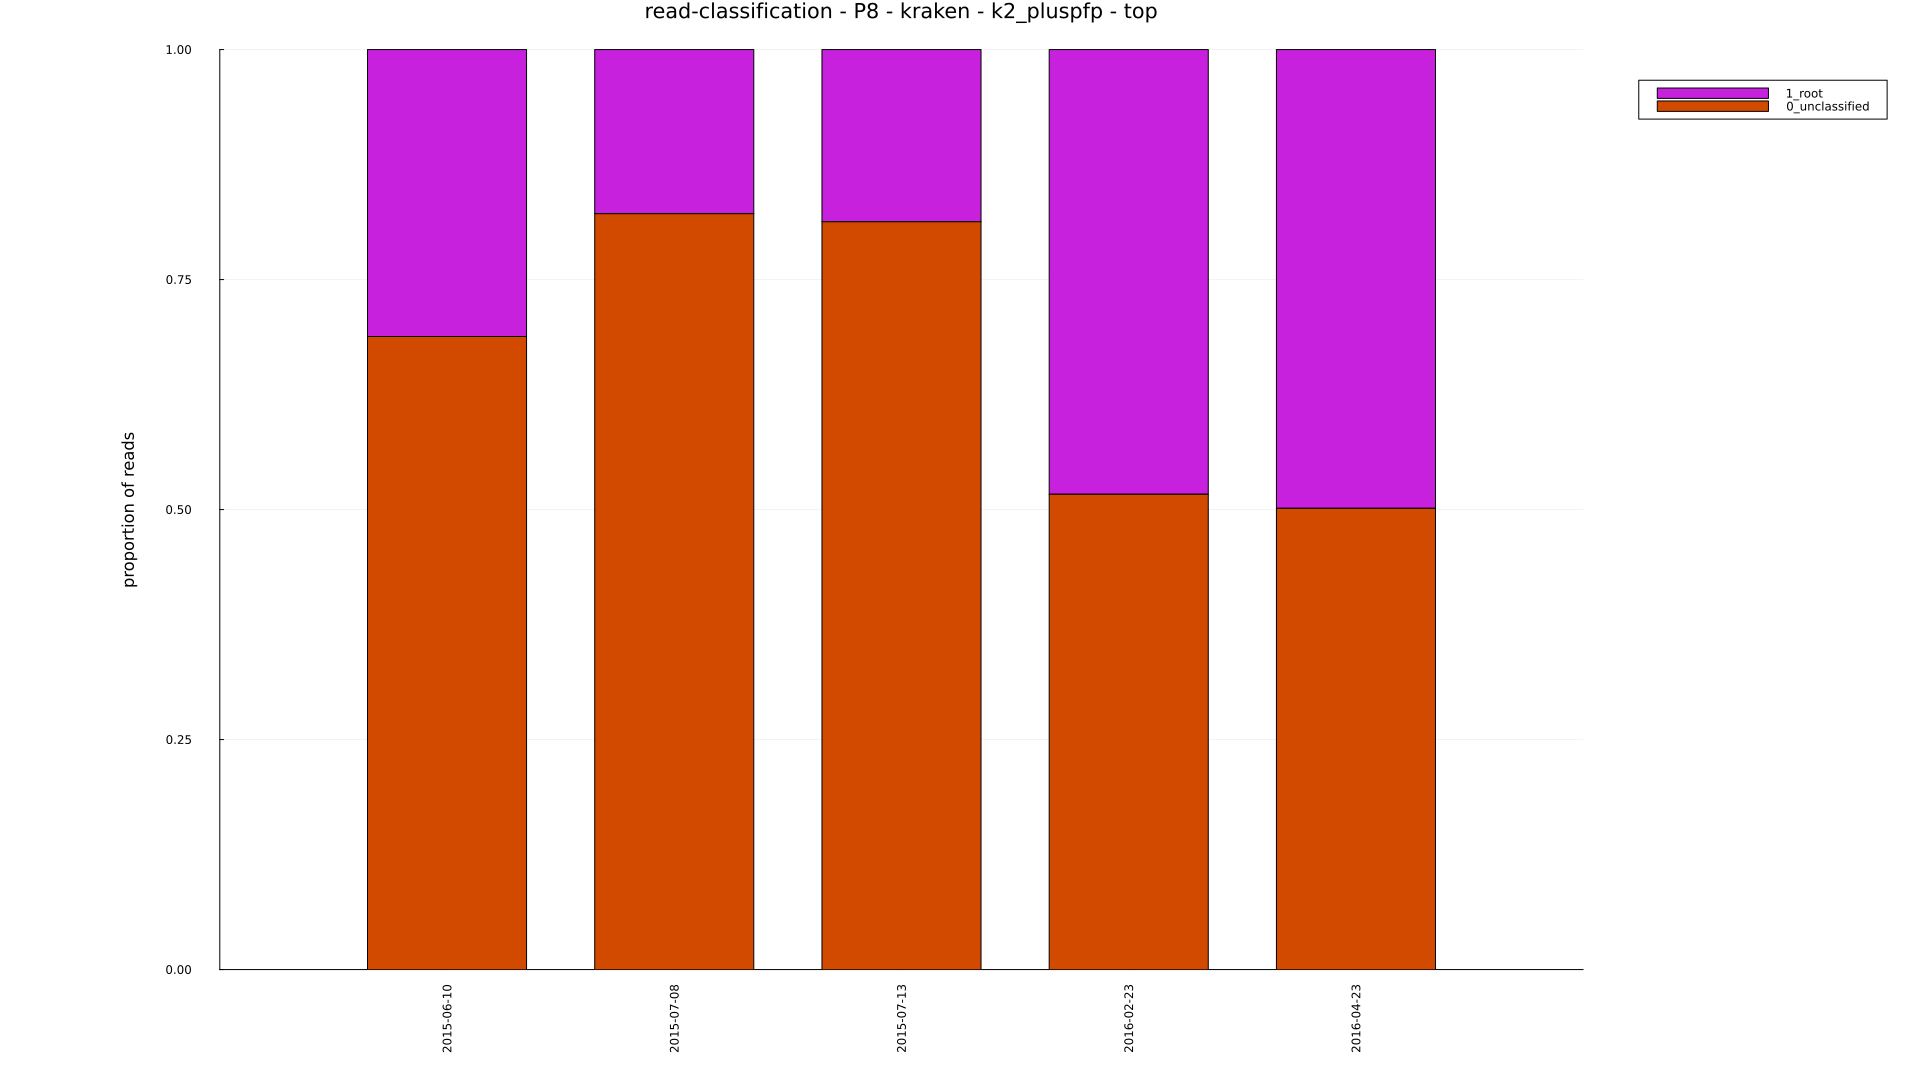

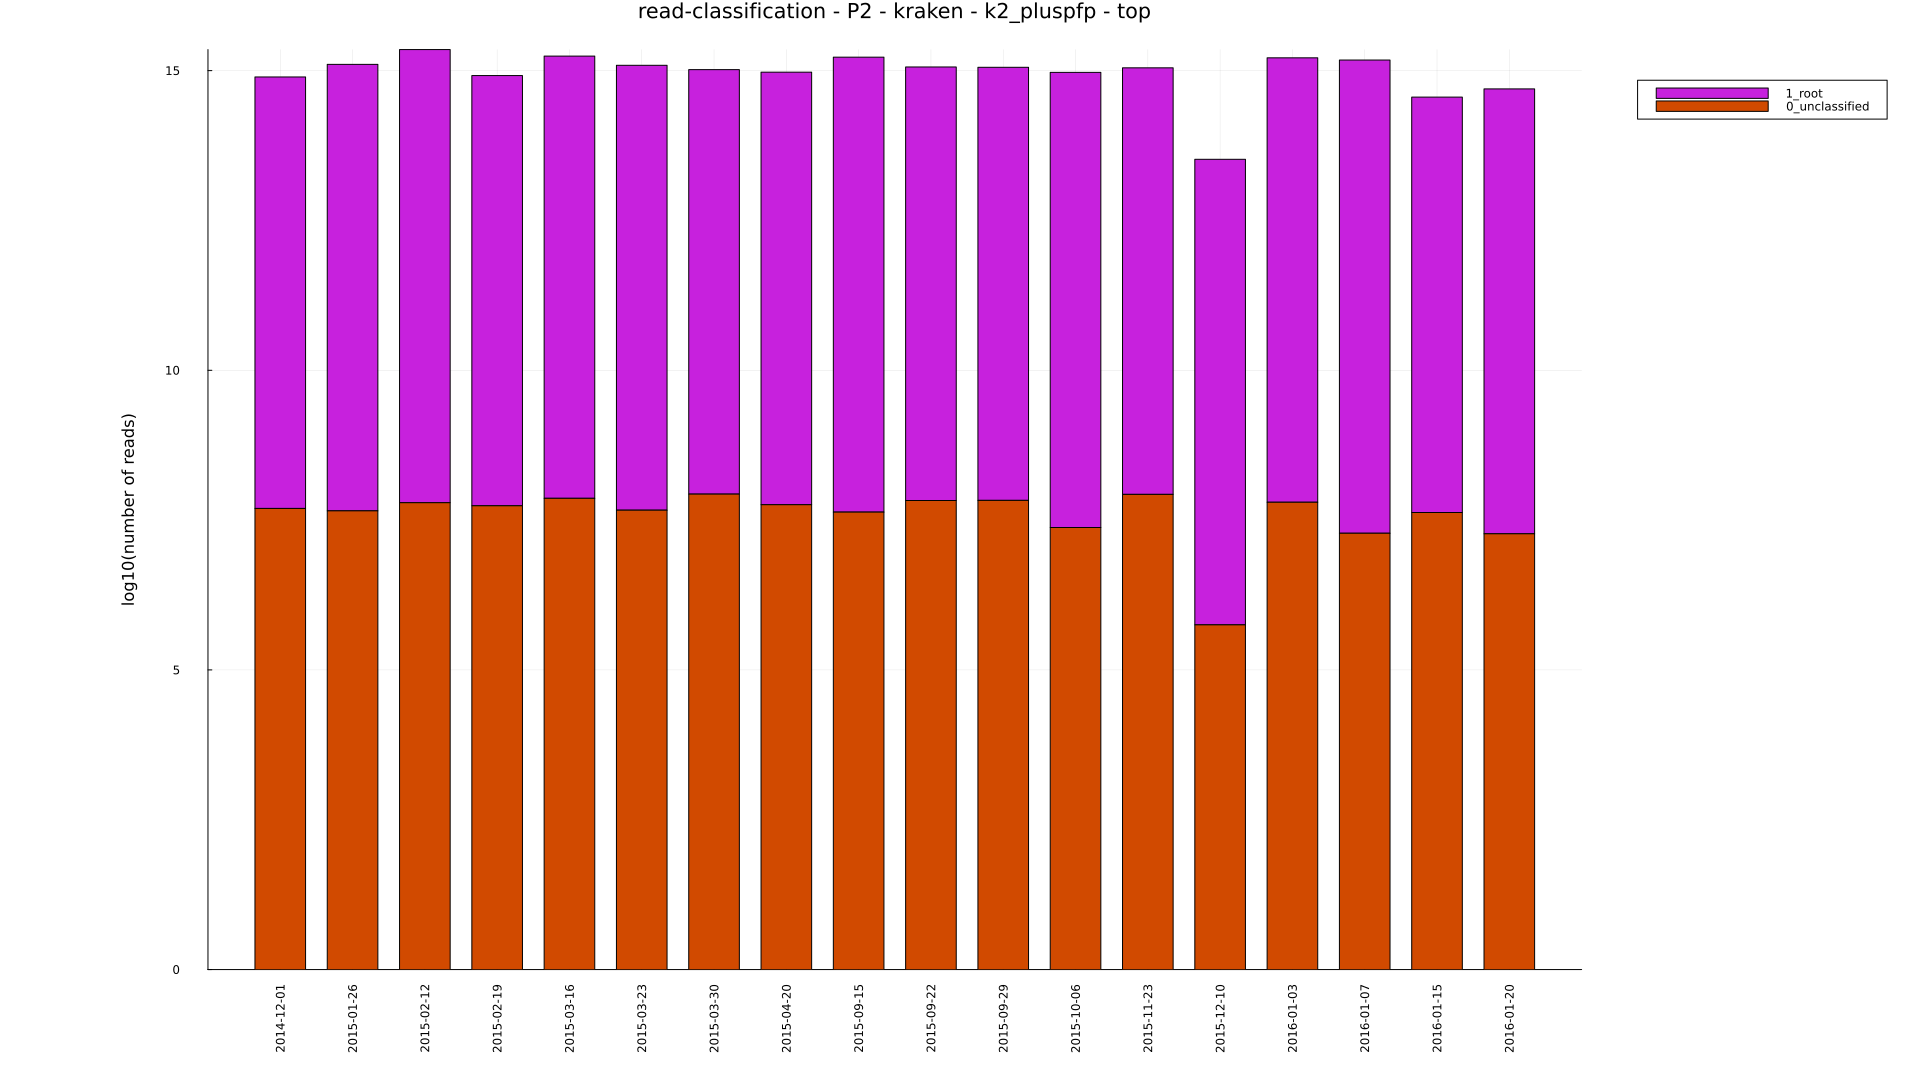

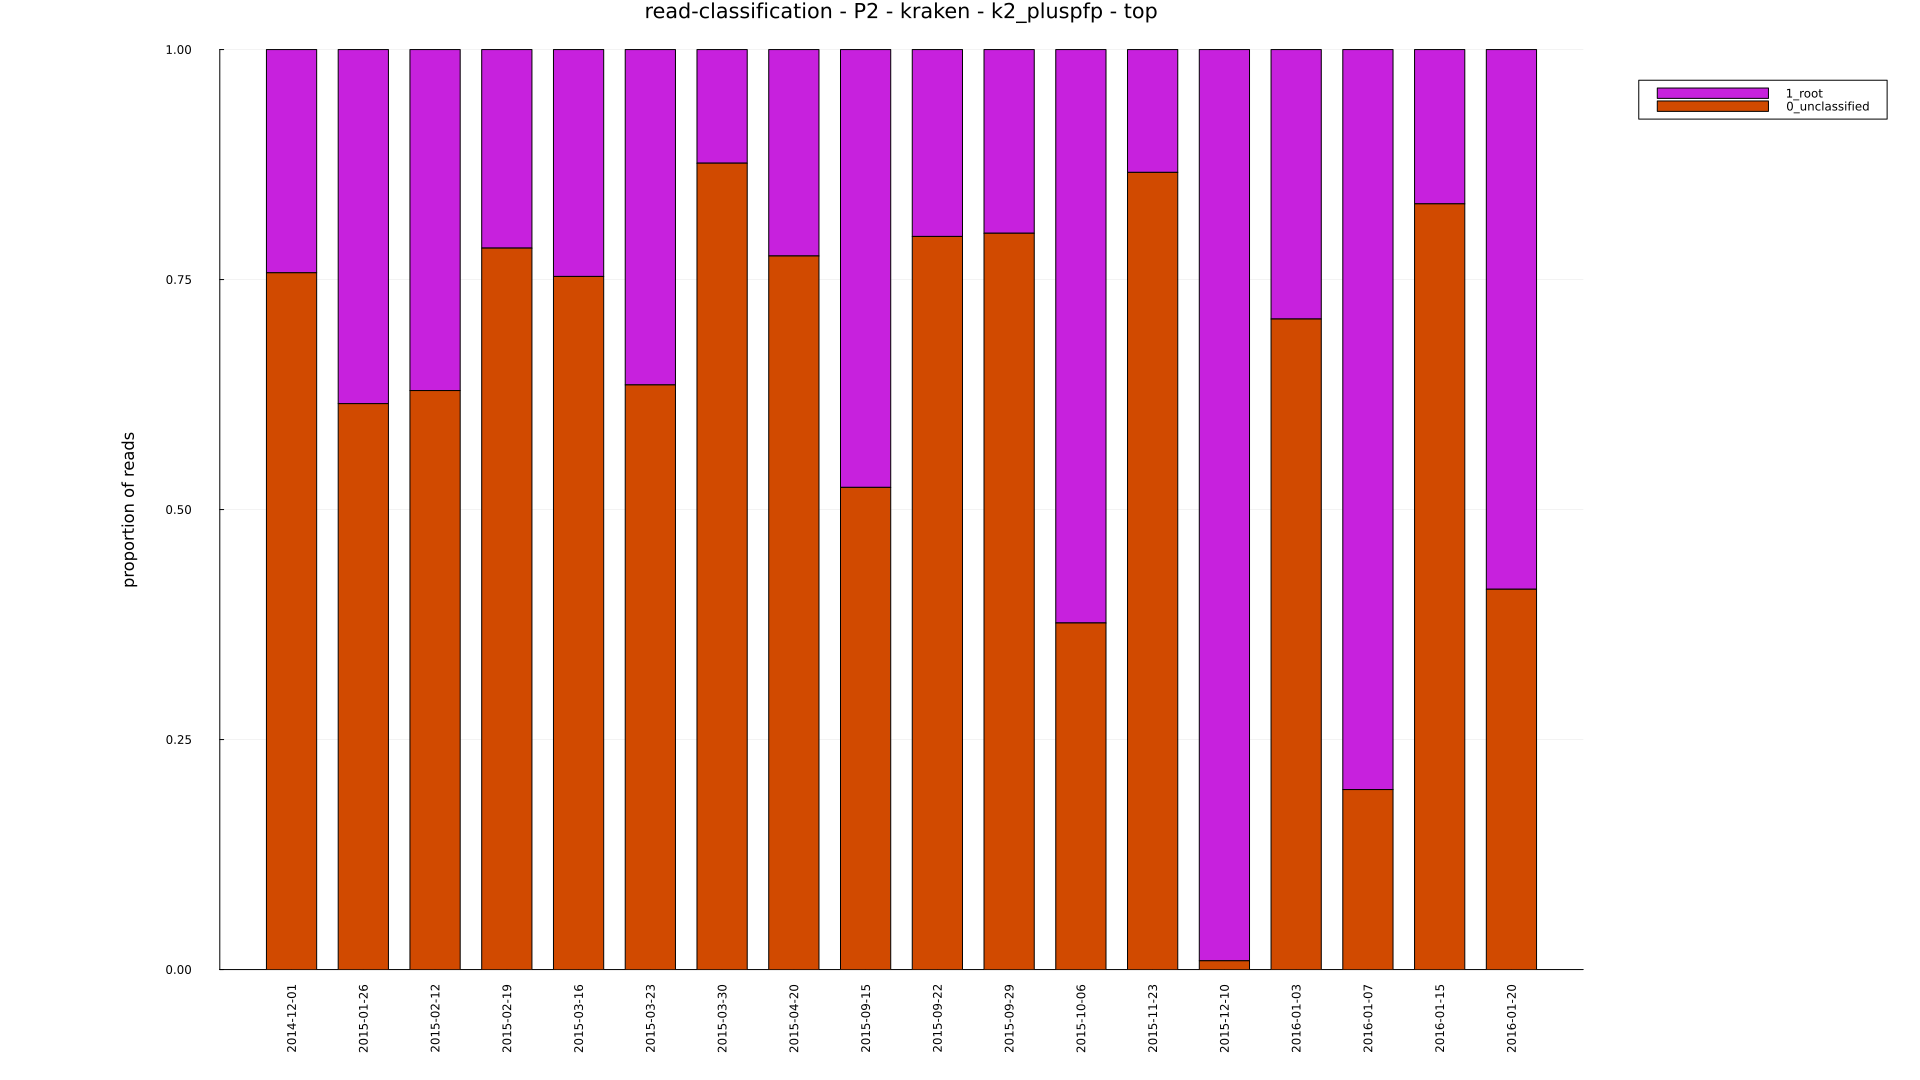

In [21]:
top_n = 60

for i in 1:9
# for i in 1:1

    participant_table = DataFrames.innerjoin(
        metadata_by_owner[i],
        cross_sample_taxon_report_summary,
        on="Run" => "sample_identifier"
    )

    participant_table = participant_table[!, [
        "aownership",
        "season",
        "geo_loc_name",
        "weekend",
        "temperature",
        "humid",
        "particle",
        "Run",
        "date.start",
        "date.end",
        "ncbi_taxonid",
        "scientific_name",
        "taxon",
        "number_of_fragments_at_or_below_taxon",
        ]]

    participant_table[!, "date.start"] = Dates.Date.(participant_table[!, "date.start"], "yyyy-mm-dd")
    participant_table[!, "date.end"] = Dates.Date.(participant_table[!, "date.end"], "yyyy-mm-dd")

    sort!(participant_table, "date.start")

    participant_table[!, "date.start_relative"] = participant_table[!, "date.start"] .- first(participant_table[!, "date.start"])

    participant_table[!, "date.end_relative"] = participant_table[!, "date.end"] .- first(participant_table[!, "date.start"])

    participant_table[!, "duration"] = participant_table[!, "date.end"] .- participant_table[!, "date.start"]

    participant = participant_table[1, "aownership"]

    participant_table

    samples = sort(unique(participant_table[!, "Run"]))
    taxon = sort(unique(participant_table[!, "taxon"]))
    samples_map = Dict(sample => i for (i, sample) in enumerate(samples))
    counts = zeros(length(samples), length(taxon))
    for (column_index, taxon_table) in enumerate(DataFrames.groupby(sort(participant_table, "taxon"), "taxon"))
        for sample_table in DataFrames.groupby(taxon_table, "Run")
            sample = sample_table[1, "Run"]
            row_index = samples_map[sample]
            @assert DataFrames.nrow(sample_table) == 1
            counts[row_index, column_index] = sum(sample_table[!, "number_of_fragments_at_or_below_taxon"])
        end
    end
    counts

    # sort taxa so largest single group is at the bottom
    frequency_ordering = sortperm(maximum.(eachcol(counts)))
    counts = counts[:, frequency_ordering]
    taxon = taxon[frequency_ordering]
    # find taxa that have no representation, and filter them out
    is_detected = [sum(col) >= 1 for col in eachcol(counts)]
    counts = counts[:, is_detected]
    taxon = taxon[is_detected]

    # # drop samples that have no data, not sure this is relevant now that we dropped negative control samples
    # sample_has_classifications = [sum(row) > 0 for row in eachrow(counts)]
    # counts = counts[sample_has_classifications, :]
    # samples = samples[sample_has_classifications]
    
    if size(counts, 2) > top_n
        counts = counts[:, (end-top_n+1):end]
    end
    
    # unique_taxa = sort(unique(participant_table[!, "ncbi_taxonid"]))
    # colorscheme = Colors.distinguishable_colors(length(unique_taxa), [Colors.RGB(1,1,1), Colors.RGB(0,0,0)], dropseed=true)

    normalized_counts = counts ./ sum(counts, dims=2)

    bottommargin = (maximum(length.(samples)) * 5)
    leftmargin = 150
    rightmargin = 25
    topmargin = 25

    width = max(1920, (size(counts, 1) * 12) + 300)
    height = max(1080, bottommargin + 600)
    height = max(height, size(counts, 2)*11)
    
    legendfontsize=12

    xtickdates = sort(unique(participant_table[!, ["date.end", "Run"]]))[!, "date.end"]

    # if i <= 2
    plot = StatsPlots.groupedbar(
        log10.(counts .+ 1),
        title = "read-classification - $(participant) - kraken - $(kraken_db) - $(taxon_level)",
        xticks = (1:length(samples), xtickdates),
        xlims = (0, length(samples)+1),
        size=(width, height),
        xrotation=90,
        ylabel = "log10(number of reads)",
        labels = hcat(taxon...),
        leftmargin = (leftmargin)StatsPlots.Plots.PlotMeasures.px,
        topmargin = (topmargin)StatsPlots.Plots.PlotMeasures.px,
        rightmargin = (rightmargin)StatsPlots.Plots.PlotMeasures.px,
        bottommargin = (bottommargin)StatsPlots.Plots.PlotMeasures.px,
        legendmargins = 0,
        legend = :outertopright,
        bar_position = :stack,
        bar_width=0.7,
        seriescolor = hcat([taxa_to_color[t] for t in taxon]...),
    )
    display(plot)
    for extension in [".png"]
        file = joinpath(results_dir, "taxonomic-breakdowns.kraken.$(kraken_db).$(taxon_index).$(taxon_level).by-participant.$(participant).total-reads") * extension
        StatsPlots.savefig(plot, file)
    end
    # end

    # if i >= 2
    plot = StatsPlots.groupedbar(
        normalized_counts,
        title = "read-classification - $(participant) - kraken - $(kraken_db) - $(taxon_level)",
        xticks = (1:length(samples), xtickdates),
        xlims = (0, length(samples)+1),
        size= (width, height),
        xrotation=90,
        ylabel = "proportion of reads",
        labels = hcat(taxon...),
        leftmargin = (leftmargin)StatsPlots.Plots.PlotMeasures.px,
        topmargin = (topmargin)StatsPlots.Plots.PlotMeasures.px,
        rightmargin = (rightmargin)StatsPlots.Plots.PlotMeasures.px,
        bottommargin = (bottommargin)StatsPlots.Plots.PlotMeasures.px,
        legendmargins = 0,
        legend = :outertopright,
        bar_position = :stack,
        bar_width=0.7,
        seriescolor = hcat([taxa_to_color[t] for t in taxon]...),
    )
    display(plot)
    for extension in [".png"]
        file = joinpath(results_dir, "taxonomic-breakdowns.kraken.$(kraken_db).$(taxon_index).$(taxon_level).by-participant.$(participant).normalized-reads") * extension
        StatsPlots.savefig(plot, file)
    end
    # end
end

In [ ]:
# full_table = DataFrames.innerjoin(joint_metadata, cross_sample_taxon_report_summary, on="Run" => "sample_identifier")

# # "date.start",
# # "date.end",
# # "ncbi_taxonid",
# # "scientific_name",
# full_table = full_table[!, [
#     # "aownership", # categorical
#     "season", # categorical
#     # "geo_loc_name", # categorical
#     # "weekend", # categorical
#     "temperature",
#     "humid",
#     "particle",
#     "Run",
#     "taxon", # categorical
#     "number_of_fragments_at_or_below_taxon",
#     ]]

# for col in [
#     # "aownership", # categorical
#     "season", # categorical
#     # "geo_loc_name", # categorical
#     # "weekend", # categorical
#     "taxon", # categorical
#     ]
#     full_table[!, col] = CategoricalArrays.categorical(full_table[!, col])
# end

# full_table[!, "temperature"] = something.(tryparse.(Float64, full_table[!, "temperature"]), missing)
# full_table[!, "humid"] = something.(tryparse.(Float64, full_table[!, "humid"]), missing)
# full_table[!, "particle"] = something.(tryparse.(Float64, full_table[!, "particle"]), missing)

# full_table = DataFrames.dropmissing(full_table)


# # get virus table
# # for future levels, need to do all of these
# taxon_table = first(DataFrames.groupby(full_table, "taxon"))

# # could use MLJ for this?
# # Splitting the data
# # train_indices, test_indices = split_indices(1:DataFrames.nrow(full_table), 0.8)
# # train_data = full_table[train_indices, :]
# # test_data = full_table[test_indices, :]

# # Define the model
# # geo_loc_name
# # weekend
# # aownership
# model = GLM.lm(GLM.@formula(number_of_fragments_at_or_below_taxon ~ particle + humid + temperature + season ), taxon_table)

# # Train the model
# # GLM.fit!(model)

# # Evaluate the model
# # predictions = GLM.predict(model, taxon_table)/

In [ ]:
# full_table = DataFrames.innerjoin(joint_metadata, cross_sample_taxon_report_summary, on="Run" => "sample_identifier")

# # "date.start",
# # "date.end",
# # "ncbi_taxonid",
# # "scientific_name",
# full_table = full_table[!, [
#     # "aownership", # categorical
#     "geo_loc_name", # categorical
#     "weekend", # categorical
#     "season", #categorical
#     "taxon", # categorical
#     "number_of_fragments_at_or_below_taxon",
#     ]]

# for col in [
#     # "aownership", # categorical
#     "season", # categorical
#     "geo_loc_name", # categorical
#     "weekend", # categorical
#     "taxon", # categorical
#     ]
#     full_table[!, col] = CategoricalArrays.categorical(full_table[!, col])
# end

# # full_table[!, "temperature"] = something.(tryparse.(Float64, full_table[!, "temperature"]), missing)
# # full_table[!, "humid"] = something.(tryparse.(Float64, full_table[!, "humid"]), missing)
# # full_table[!, "particle"] = something.(tryparse.(Float64, full_table[!, "particle"]), missing)

# full_table = DataFrames.dropmissing(full_table)


# # get virus table
# # for future levels, need to do all of these
# taxon_table = first(DataFrames.groupby(full_table, "taxon"))

# # could use MLJ for this?
# # Splitting the data
# # train_indices, test_indices = split_indices(1:DataFrames.nrow(full_table), 0.8)
# # train_data = full_table[train_indices, :]
# # test_data = full_table[test_indices, :]

# # Define the model
# # geo_loc_name
# # weekend
# # aownership
# model = GLM.lm(GLM.@formula(number_of_fragments_at_or_below_taxon ~ geo_loc_name + weekend + season), taxon_table)

# # Train the model
# # GLM.fit!(model)

# # Evaluate the model
# # predictions = GLM.predict(model, taxon_table)/